# Adventures in mosaic density!

Let's see what happens to optimal filters (a la Atick and Redlich) when we change the density of the mosaic.

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib 
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline

import seaborn as sns
import scipy.optimize as opt
import scipy.signal as ssig
from scipy.interpolate import interp1d
from scipy.special import softmax
import scipy

def softplus(x, beta=1): return np.log1p(np.exp(-np.abs(beta * x)))/beta + np.maximum(x, 0)

plt.rcParams.update({
    "text.usetex": True,
})

sns.set_context('talk')

%config InlineBackend.figure_format = 'retina'

np.random.seed(12346)

# First, let's set up some problem dimensions:

In [3]:
L = 10  # linear size of space in one dimension
T = 5 # size of time
N = 1001 # number of points
M = 1001
zz = np.linspace(-L/2, L/2, N)
tt = np.linspace(-T/2, T/2, M)
dz = zz[1] - zz[0]
dt = tt[1] - tt[0]

# Now assuming $C_x = \frac{A}{k^\alpha\omega^2}$, let's calculate the Atick and Redlich filter.

In [4]:
sigin = 1
sigout = 1.25
#A = np.array([100])
A = np.array([100,100,100])
alpha = 1.3

def soft_bandpass(lo, hi, freqs, stiffness=10):
    if lo <= 0:
        return scipy.special.expit(stiffness * (hi - freqs))
    else:
        return scipy.special.expit(stiffness * (freqs - lo)) * scipy.special.expit(stiffness * (hi - freqs))

#Original version of the code
def C_prev(k, o):
    return A/(np.abs(k)**alpha * np.abs(o)**2)

def C(k,o,i):
    eigval = A[i]/(np.abs(k)**alpha * np.abs(o)**2)  
    return eigval

In [5]:
k_logrange = np.logspace(-3, 11, 100)
o_logrange = np.logspace(-3, 11, 100)

In [6]:
def filter(A, sigin, sigout, nu, k_lims=None, o_lims=None):
    def v_opt(k, omega, i):
        sqrt_piece = np.sqrt(1 + (4/nu) * (sigin**2/sigout**2) * k**alpha * omega**2/A[i])
        v2 = 0.5 * (sqrt_piece + 1) * A[i] / (A[i] + sigin**2 * k**alpha * omega**2) - 1
        v2 = np.sqrt(np.maximum(v2, 0) * sigout**2/sigin**2)
        
        if k_lims:
            unit_cell_k = soft_bandpass(k_lims[0], k_lims[1], k)
            v2 *= unit_cell_k
        if o_lims:
            unit_cell_o = soft_bandpass(o_lims[0], o_lims[1], omega)
            v2 *= unit_cell_o
            
        return v2
    return v_opt

And redefine functions so that the filter can be bandwidth-constrained:

In [7]:
freqs_k = scipy.fft.fftfreq(N, d=dz) * np.pi
freqs_omega = scipy.fft.fftfreq(M, d=dt) * np.pi

freqs_k_small = freqs_k[(freqs_k > 0)]
freqs_omega_small = freqs_omega[(freqs_omega > 0)]

oo, kk = np.meshgrid(freqs_omega_small, freqs_k_small)

In [8]:
nu = 1e-3
vfun = filter(A, sigin, sigout, nu)

C:\Users\David\AppData\Local\Temp\ipykernel_6056\3363473031.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.contour(np.log(oo), np.log(kk), np.log10(v), levels=11)


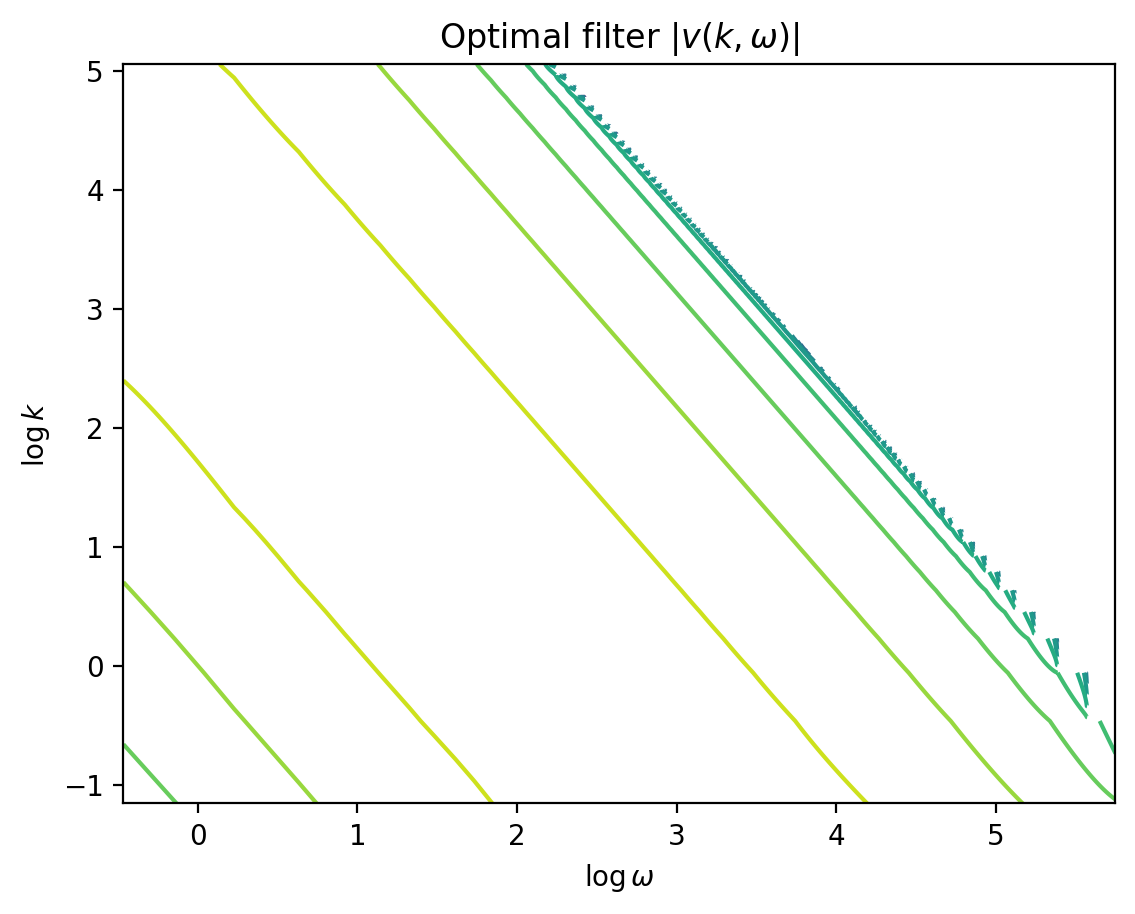

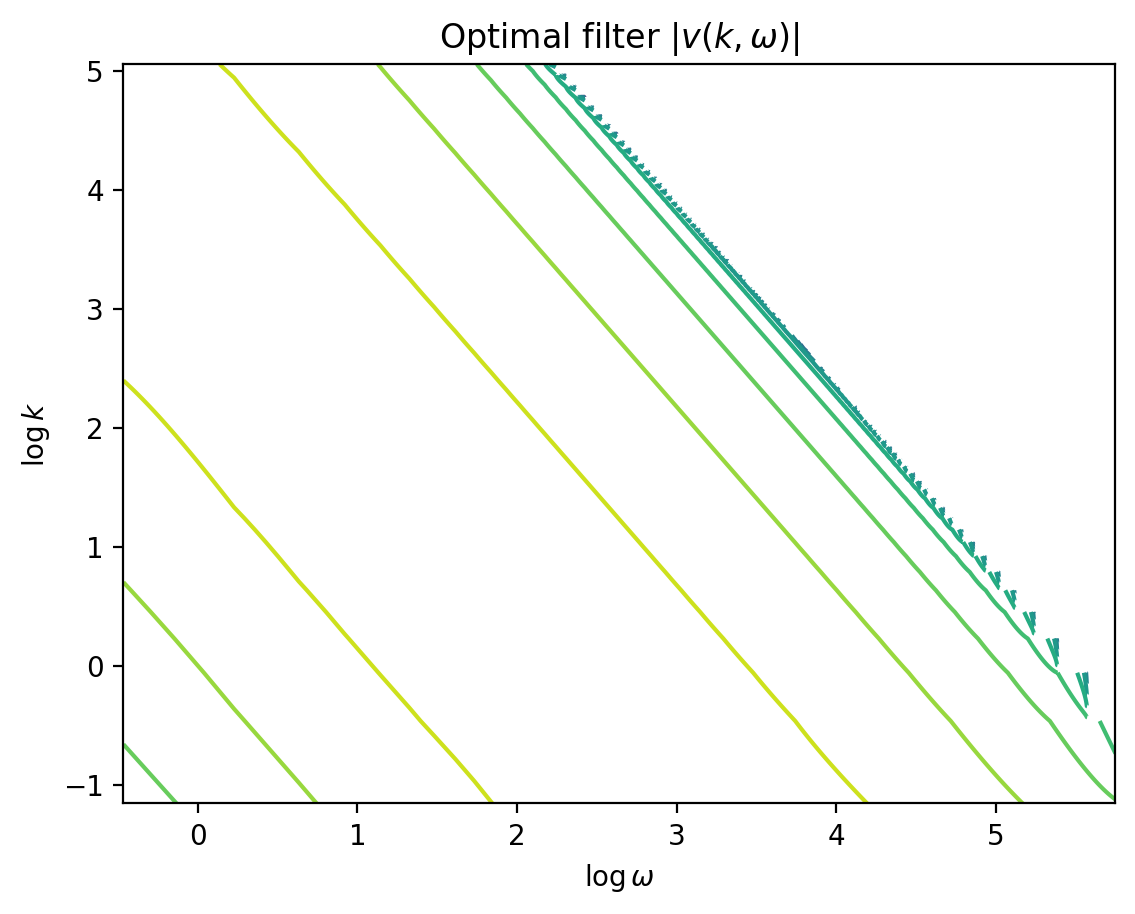

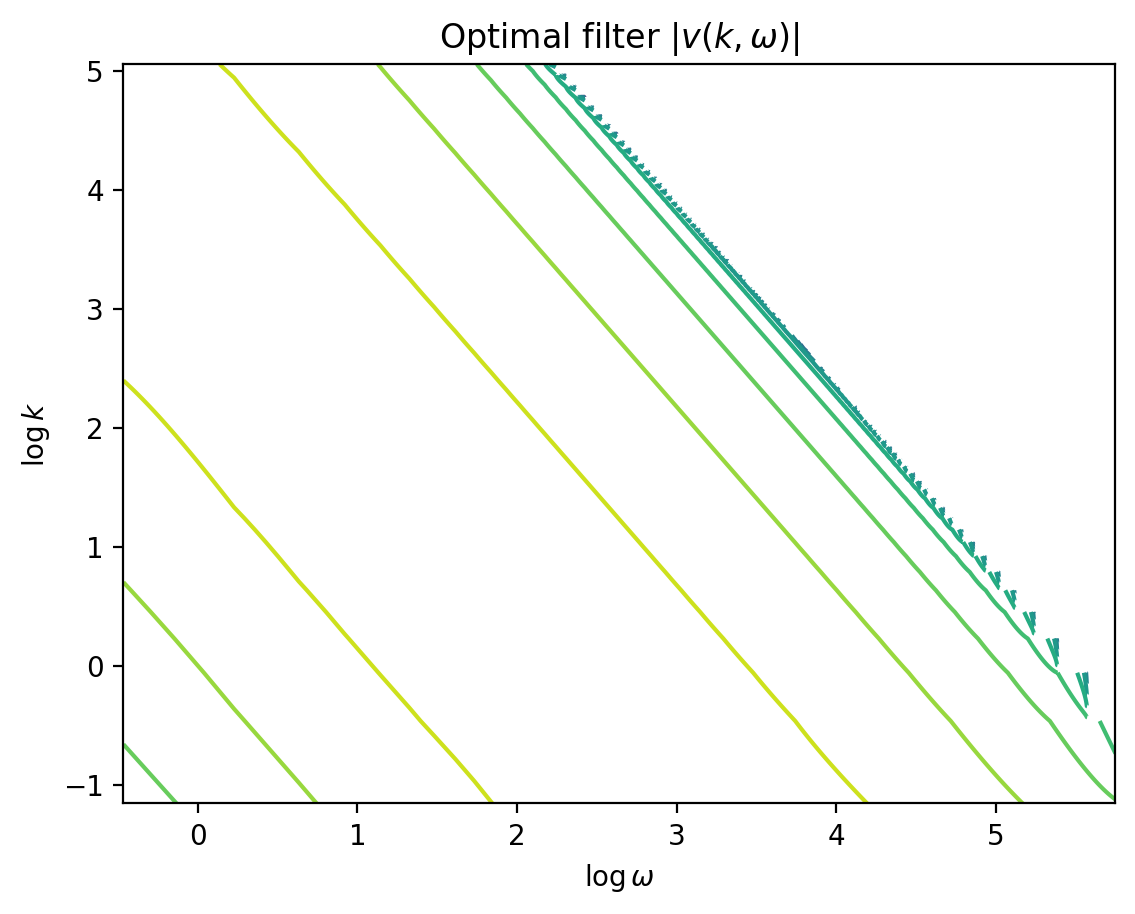

In [9]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline
for i in range(A.shape[0]):
    v = vfun(kk, oo, i)
    Ck = C(kk, oo, i)
    plt.figure()
    plt.contour(np.log(oo), np.log(kk), np.log10(v), levels=11)
    plt.title(r"Optimal filter $|v(k, \omega)|$")
    plt.ylabel(r"$\log k$")
    plt.xlabel(r"$\log \omega$");

# Power as a function of $\nu$

In [10]:
def filter_power(nu, omega0, k_lims, i):
    vfun = filter(A, sigin, sigout, nu)
    func = lambda k: k * (vfun(k, omega0,i)**2) * (C(k, omega0, i) + sigin**2)/(2 * np.pi)**2
    return scipy.integrate.quad(func, k_lims[0], k_lims[1])[0]

def filter_power_log_k(nu, omega0, log_k_lims):
    """Integrate power in psi = log k space."""
    vfun = filter(A, sigin, sigout, nu)
    func = lambda psi: np.exp(2 * psi) * vfun(np.exp(psi), omega0**2) * (C(np.exp(psi), omega0) + sigin**2)/(2 * np.pi)**2
    return scipy.integrate.quad(func, log_k_lims[0], log_k_lims[1])[0]

In [11]:
%%time
nu_list = np.logspace(-10, 0, 50) #[1e-6 , 1e-5, 1e-4, 0.005, 0.01, 0.05]

k_lims = (1e-3, 1e3)
omega0 = 10**1.2
pow_list = [filter_power(nu, omega0, k_lims, 0) for nu in nu_list]

CPU times: total: 297 ms
Wall time: 268 ms


# Bringing it all together

C:\Users\David\AppData\Local\Temp\ipykernel_6056\3810808532.py:16: RuntimeWarning: divide by zero encountered in log10
  ax[0, 0].plot(np.log10(k_logrange), np.log10(v2), color='k')
C:\Users\David\AppData\Local\Temp\ipykernel_6056\3810808532.py:27: RuntimeWarning: divide by zero encountered in log10
  ax[0, 0].fill_between(np.log10(k_logrange[right_side]), np.log10(v2[right_side]), -11, color='orange', alpha=0.5, edgecolor='none')
C:\Users\David\AppData\Local\Temp\ipykernel_6056\3810808532.py:54: RuntimeWarning: divide by zero encountered in log10
  ax[0, 1].plot(np.log10(k_logrange), 10 * np.log10(power), label=np.around(np.log10(log_o), 1), color=cmap[idx])
C:\Users\David\AppData\Local\Temp\ipykernel_6056\3810808532.py:69: RuntimeWarning: divide by zero encountered in log10
  ax[1, 1].plot(np.log10(pow_list), np.log10(nu_list), color='k')


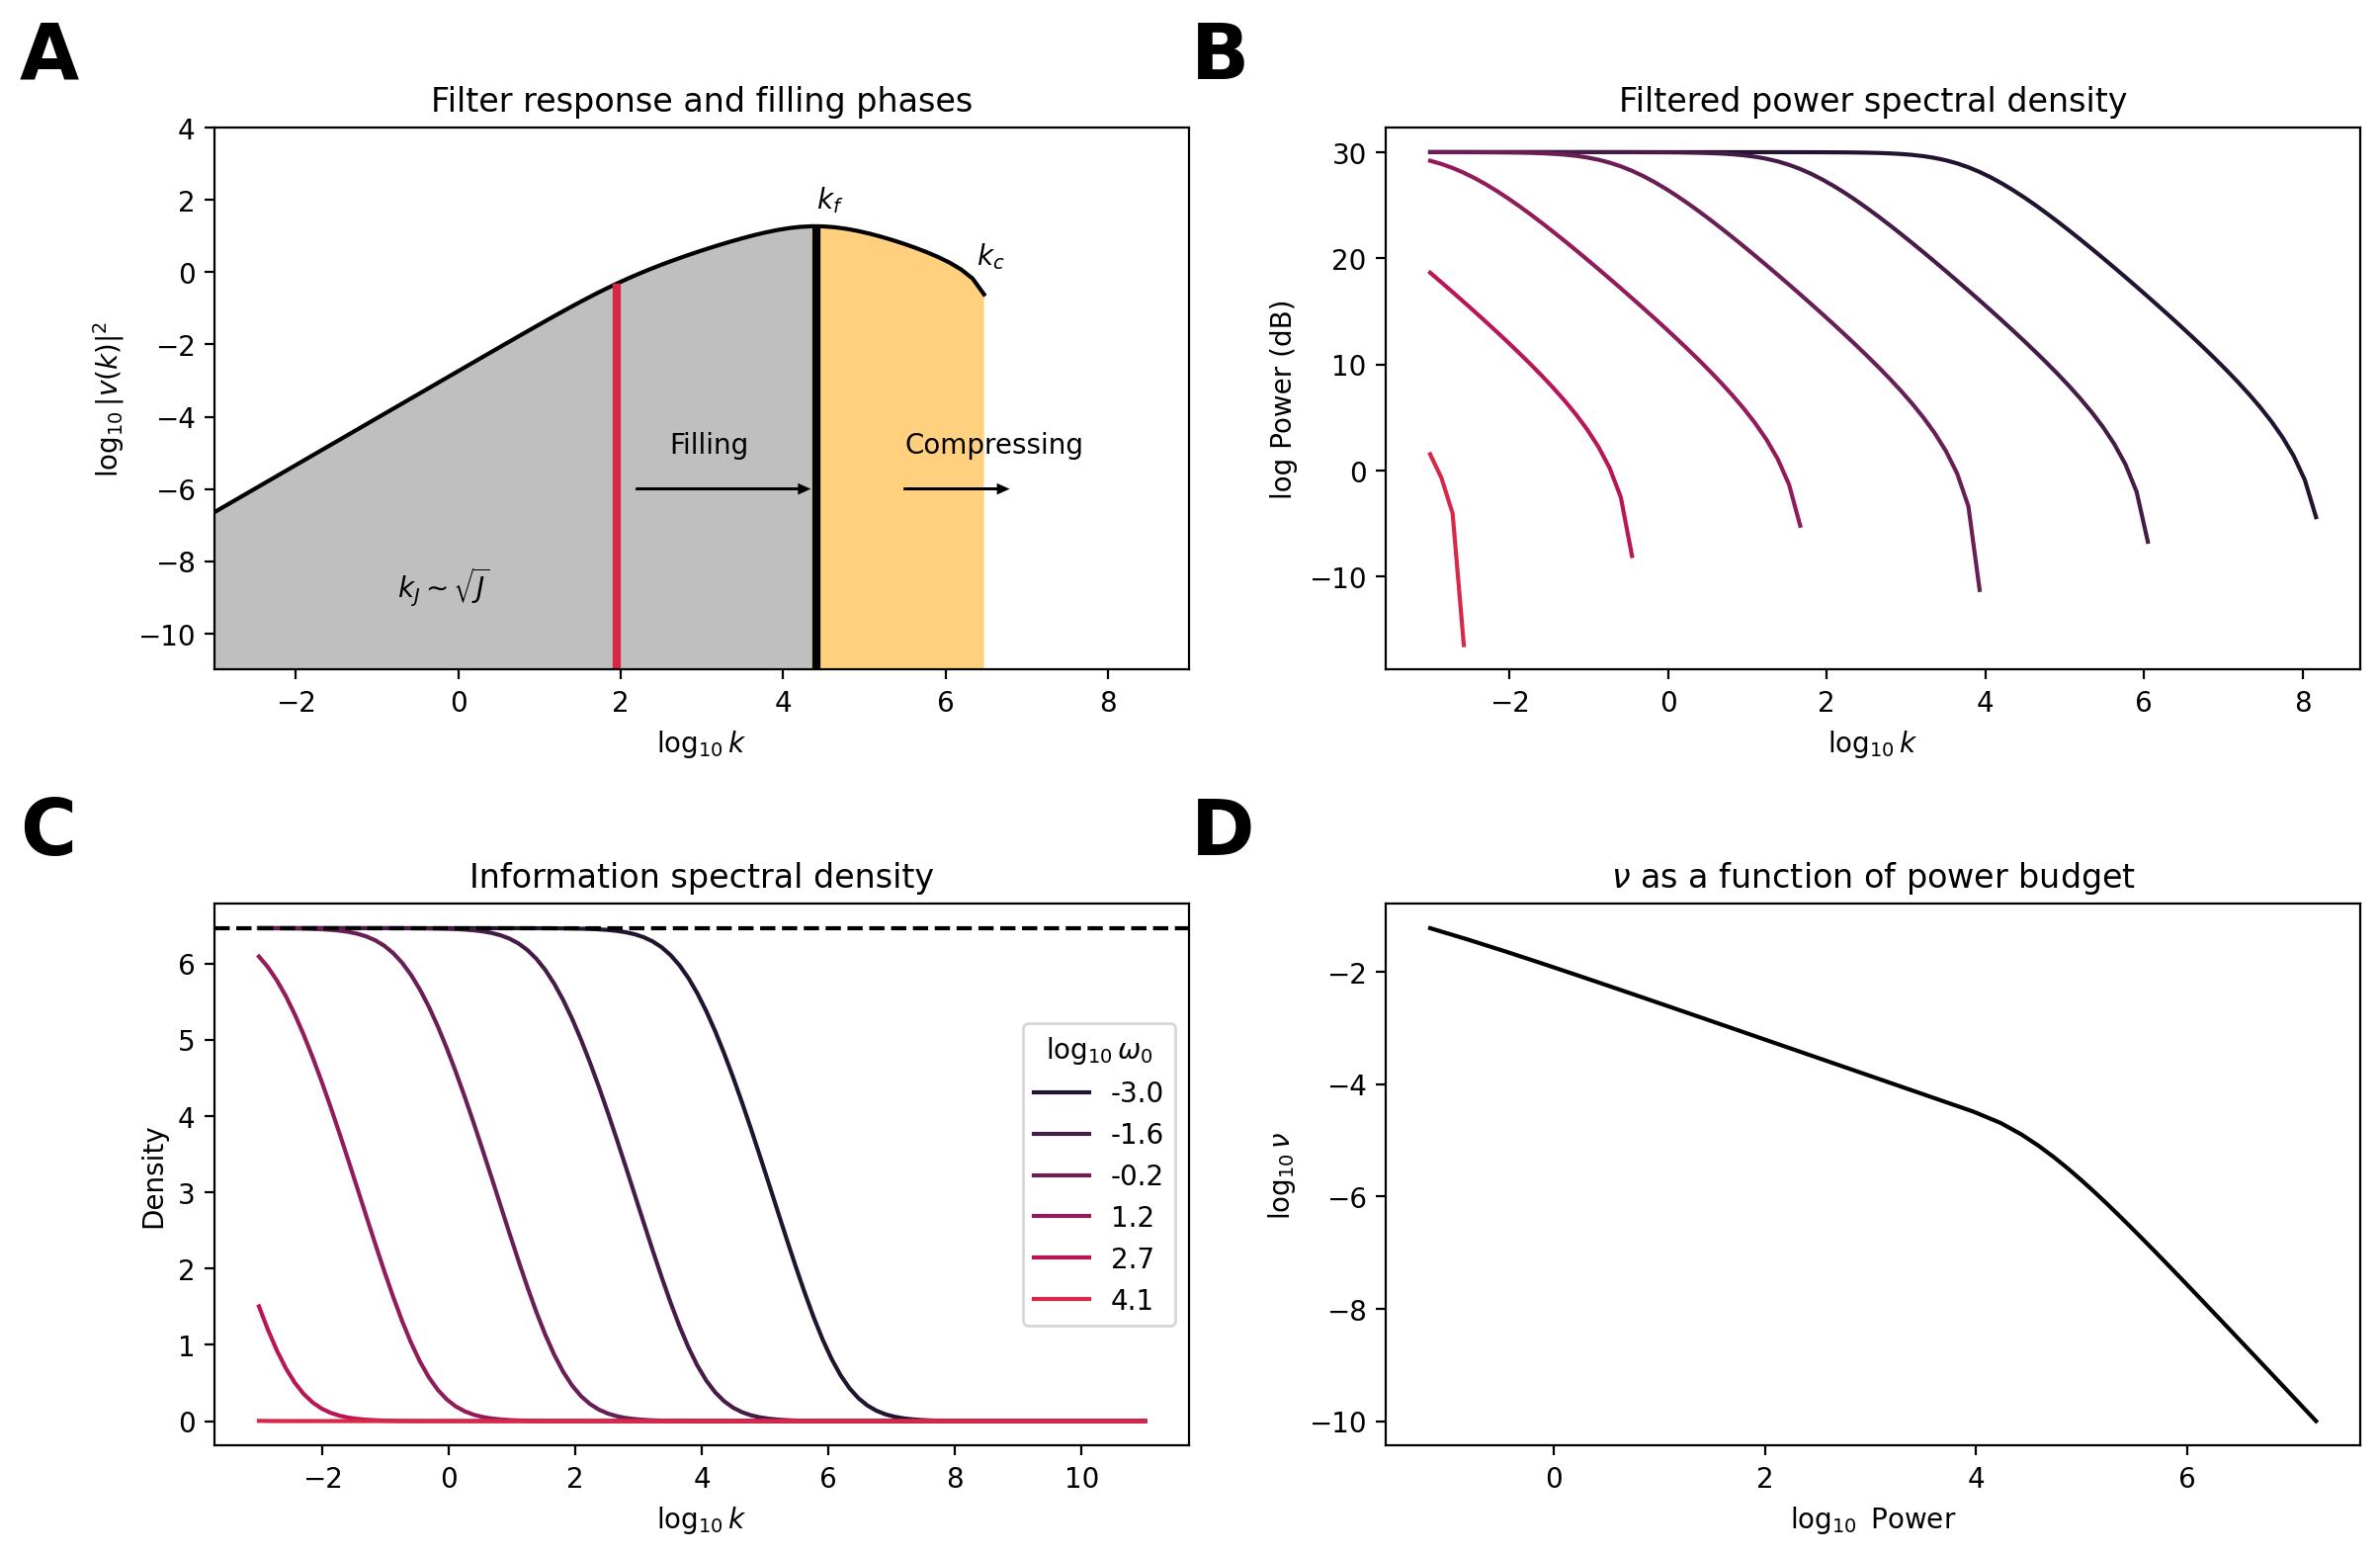

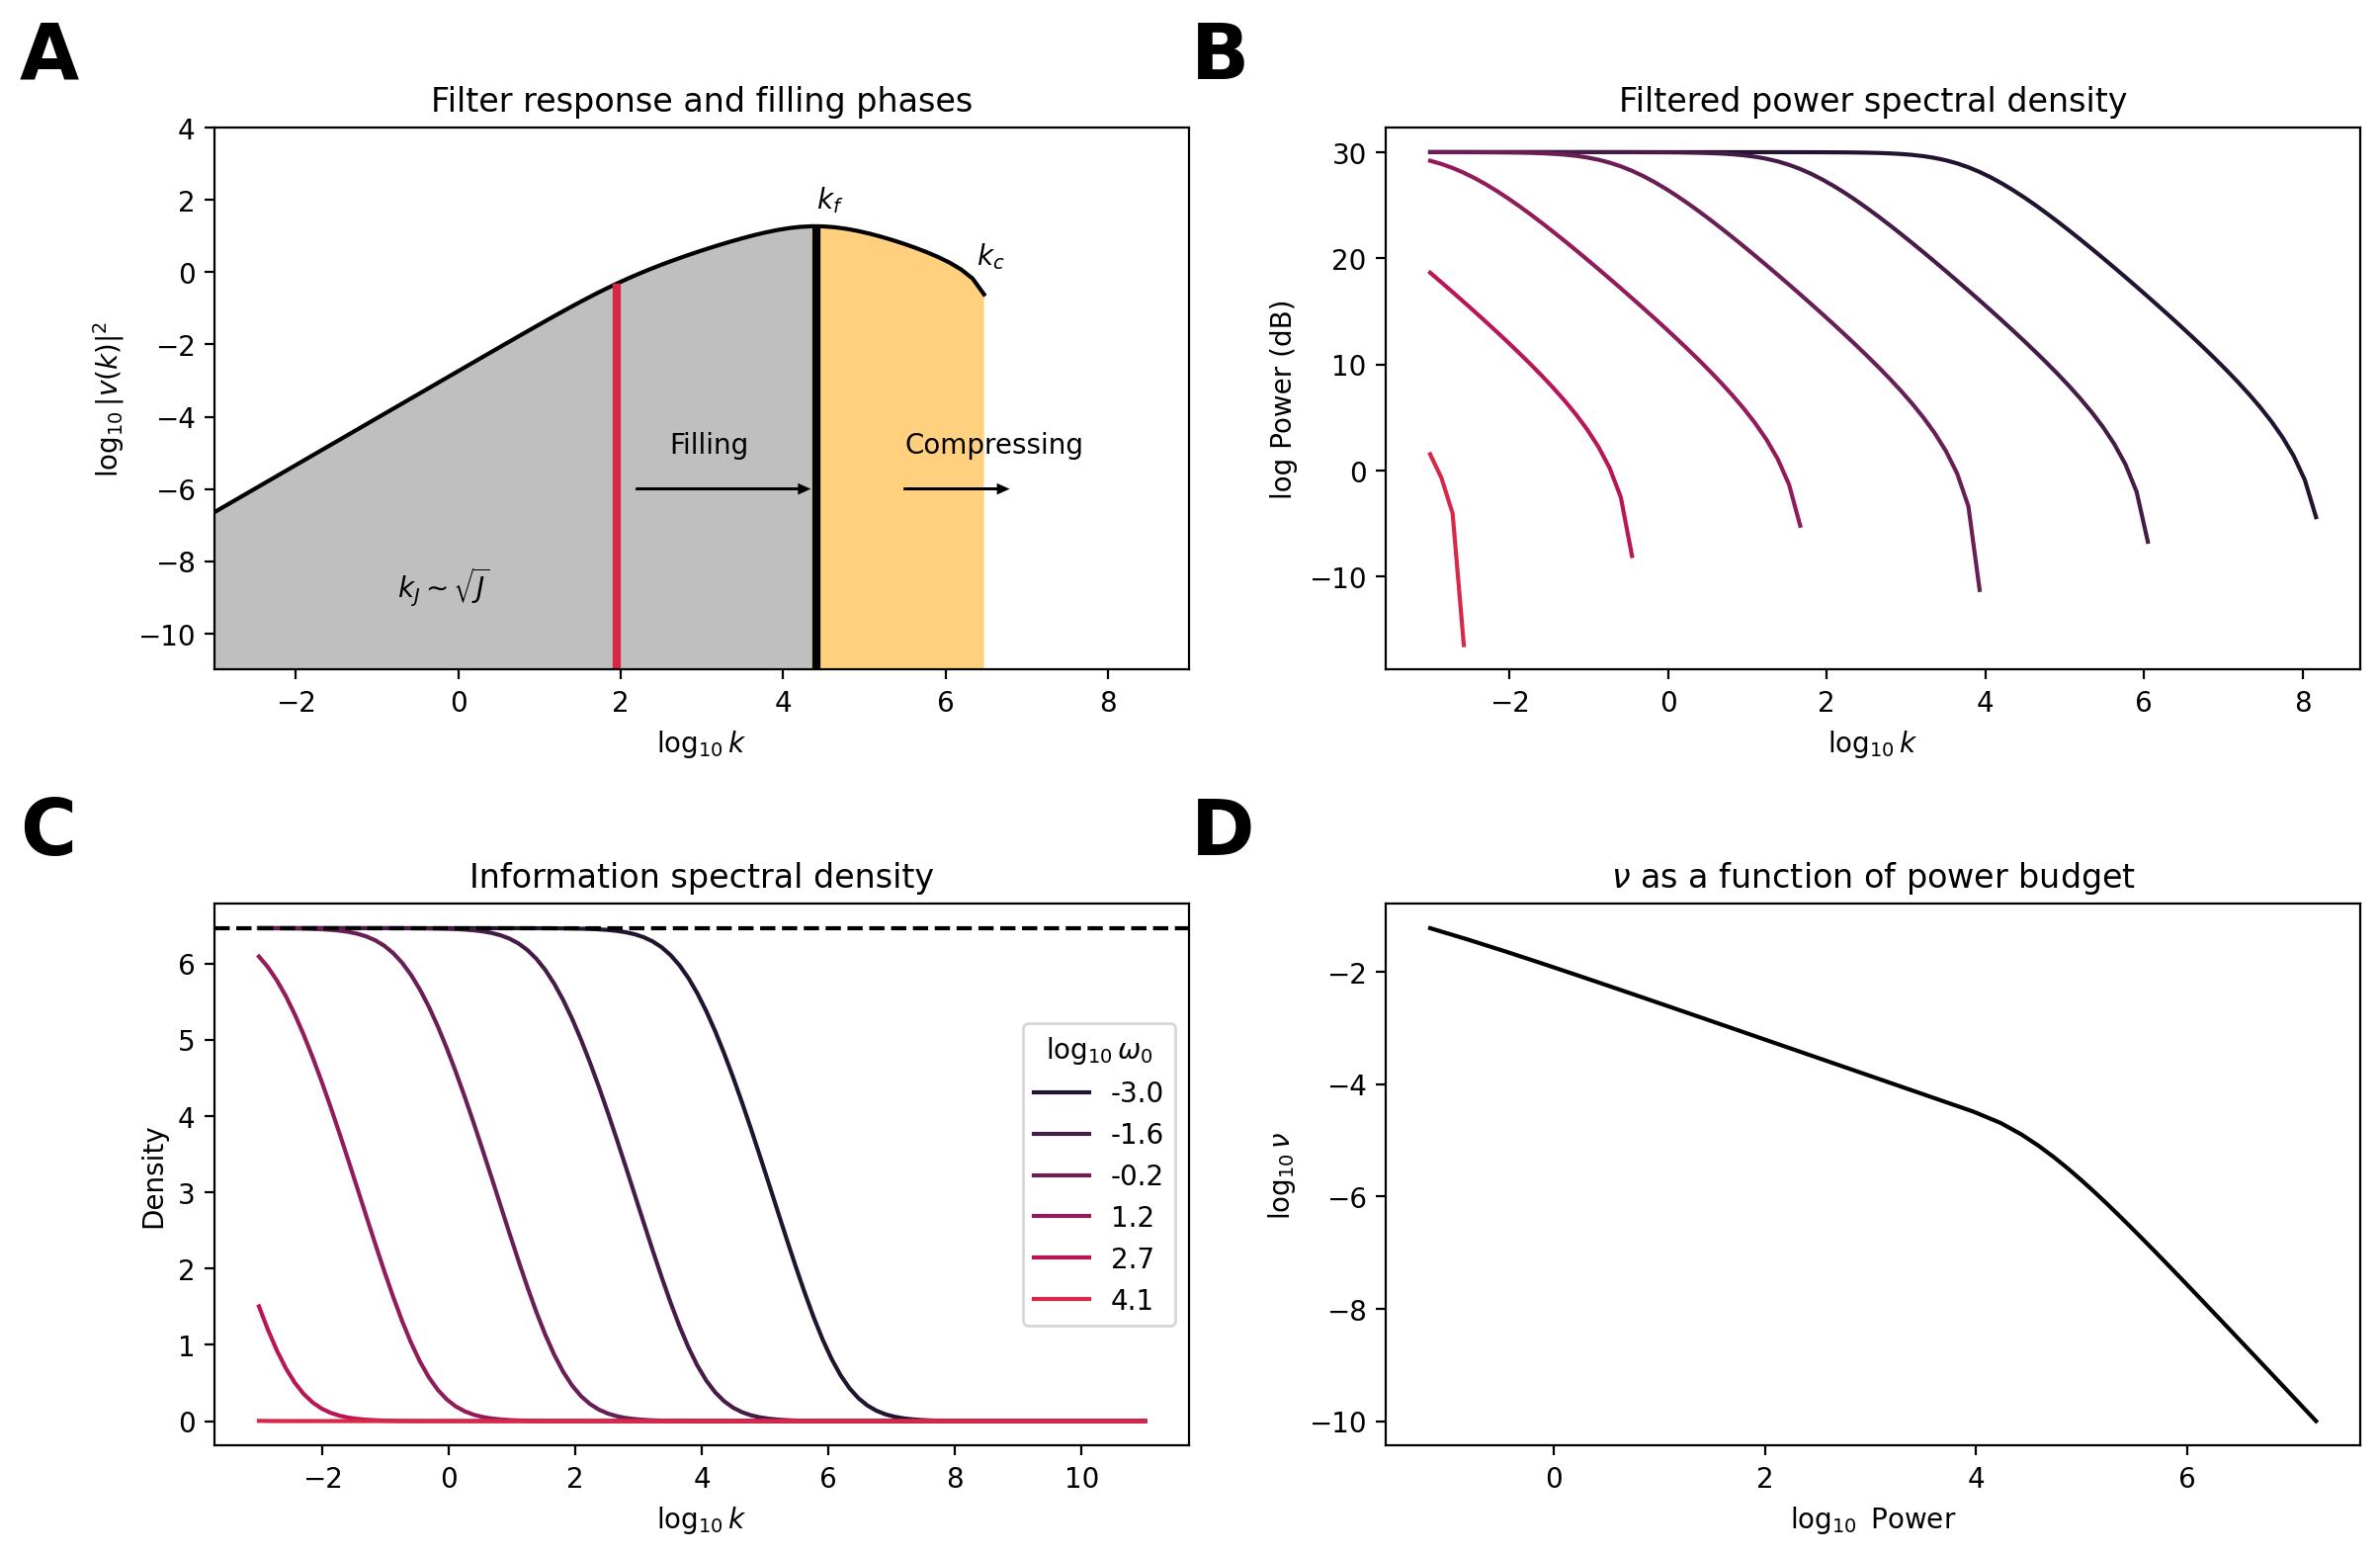

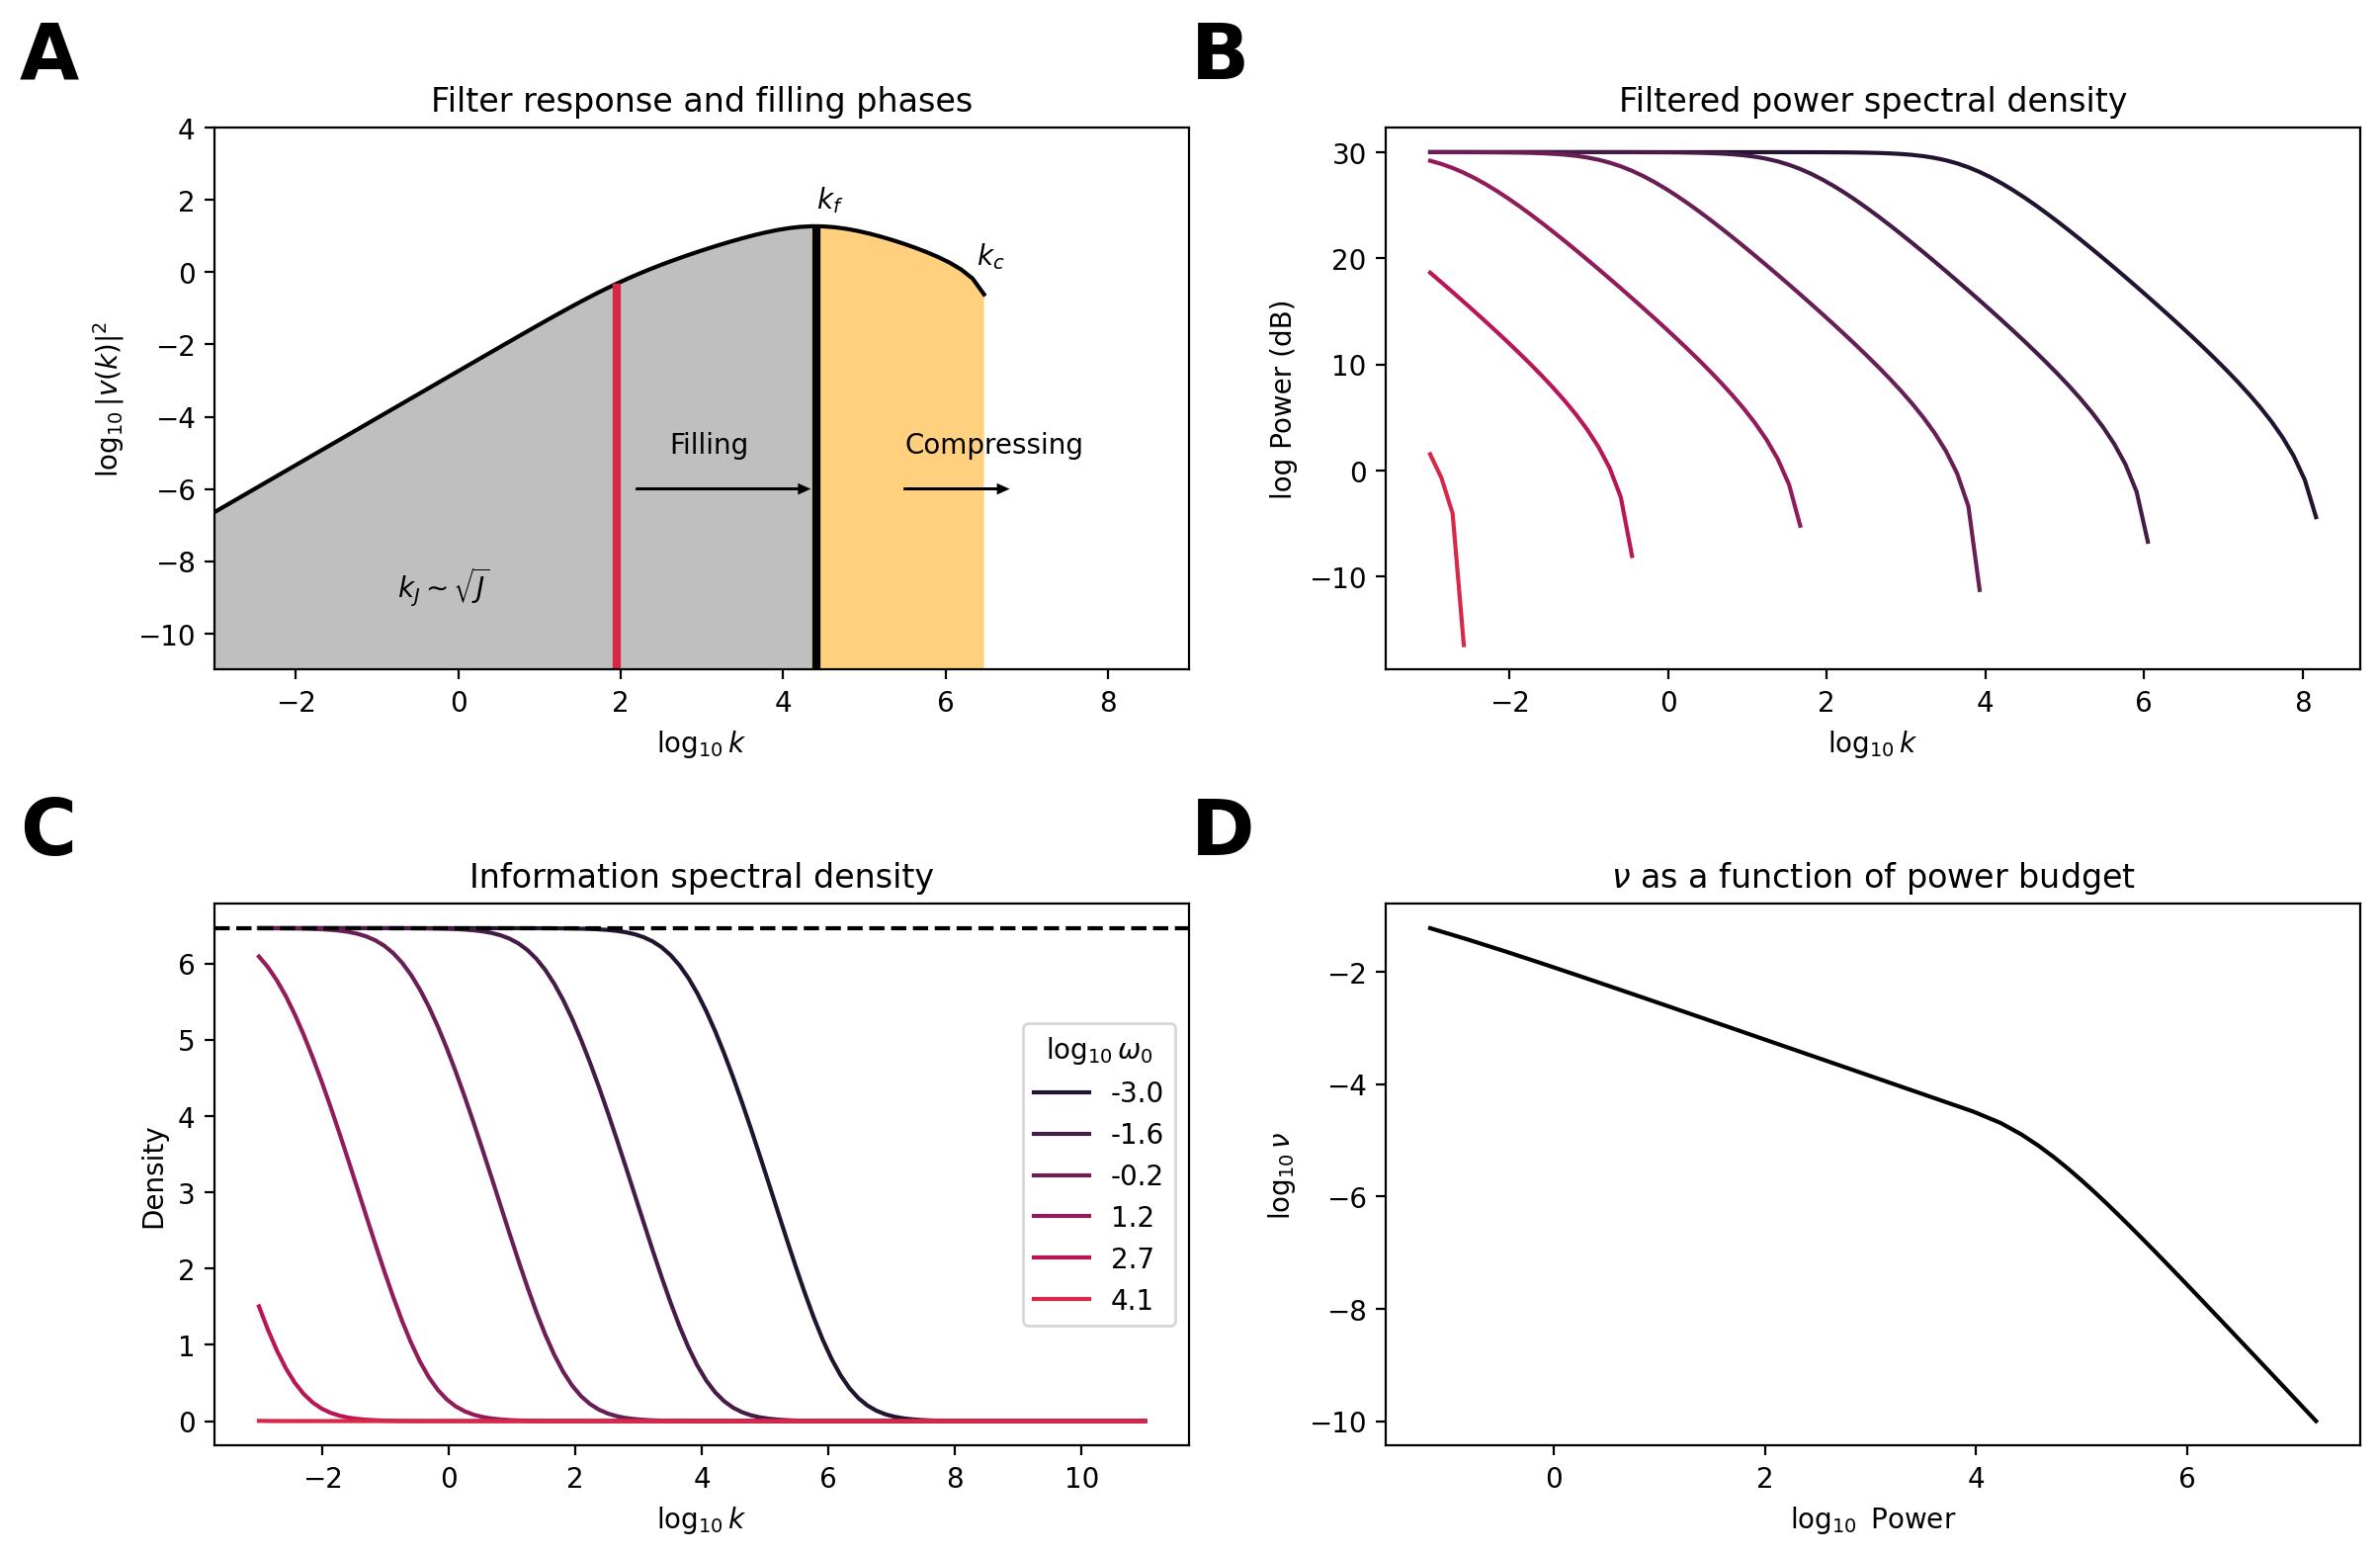

In [12]:

for i in range(A.shape[0]):
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    cmap = sns.color_palette('rocket', 10)
    label_loc = (-0.2, 1.2)
    fontsize=28
    fontweight='heavy'
    
    k_logrange = np.logspace(-3, 11, 100)
    o_logrange = np.logspace(-3, 11, 100)
    
    idx = 8



    v2 = vfun(k_logrange, o_logrange[idx], i)**2
    ax[0, 0].plot(np.log10(k_logrange), np.log10(v2), color='k')
    log_kp = (np.log10(A[i]) - 2 * np.log10(sigin) - 2 * np.log10(o_logrange[idx]))/alpha
    log_v2_kp = 2 * np.log10(vfun(10**log_kp, o_logrange[idx], i))
    log_kc = log_kp - (np.log10(nu) + 2 * np.log(sigout))/alpha
    log_v2_kc = 2 * np.log10(vfun(10**log_kc, o_logrange[idx], i))
    
    ax[0, 0].vlines(log_kp, -11, log_v2_kp, color='k', linewidth=3)
    nearest_idx = np.argmin(np.abs(k_logrange - 10**log_kp))
    left_side = slice(0, nearest_idx + 1) #k_logrange[:nearest_idx] <= 10**log_kp
    right_side = slice(nearest_idx, -1) #k_logrange[nearest_idx:] >= 10**log_kp
    ax[0, 0].fill_between(np.log10(k_logrange[left_side]), np.log10(v2[left_side]), -11, color='gray', alpha=0.5, edgecolor='none')
    ax[0, 0].fill_between(np.log10(k_logrange[right_side]), np.log10(v2[right_side]), -11, color='orange', alpha=0.5, edgecolor='none')
    ax[0, 0].set_xlim(-3, 9)
    ax[0, 0].set_ylim(-11, 4)
    ax[0, 0].annotate(r"Filling", (2.6, -5))
    ax[0, 0].arrow(2.2, -6, 2, 0, head_width=0.2, head_length=0.1, color='k')
    lower_idx, upper_idx = 35, 70
    linecolor = cmap[5] #(227/255, 74/255, 51/255)
    ax[0, 0].vlines(np.log10(k_logrange[lower_idx]), -11, np.log10(v2[lower_idx]), color=linecolor, linewidth=3, zorder=2)
    # ax[0, 0].vlines(np.log10(k_logrange[upper_idx]), -3.55, np.log10(v2[upper_idx]), color=linecolor, linewidth=3, zorder=1)
    # ax[0, 0].vlines(np.log10(k_logrange[upper_idx]), -11, -5.8, color=linecolor, linewidth=3, zorder=1)
    ax[0, 0].annotate(r"$k_J \sim \sqrt{J}$", (np.log10(k_logrange[lower_idx]) - 2.7, -9))
    ax[0, 0].annotate(r"Compressing", (5.5, -5))
    # ax[0, 0].annotate(r"$\frac{\pi}{\Delta z(J)}$", (np.log10(k_logrange[upper_idx]) + .5, -9))
    ax[0, 0].arrow(5.5, -6, 1.15, 0, head_width=0.2, head_length=0.1, color='k')
    ax[0, 0].annotate(r"$k_f$", (log_kp, log_v2_kp + 0.5))
    ax[0, 0].annotate(r"$k_c$", (log_kc, log_v2_kc + 0.5))
    ax[0, 0].set_title(r"Filter response and filling phases")
    ax[0, 0].set_xlabel(r"$\log_{10} k$")
    ax[0, 0].set_ylabel(r"$\log_{10} |v(k)|^2$");
    ax[0, 0].text(*label_loc, "A", transform=ax[0, 0].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')
    
    
    for idx, log_o in enumerate(o_logrange[:60:10]):
        numer = vfun(k_logrange, log_o, i)**2 * (C(k_logrange, log_o, i) + sigin**2) + sigout**2
        denom = vfun(k_logrange, log_o, i)**2 * (sigin**2) + sigout**2
        power = vfun(k_logrange, log_o, i)**2 * (C(k_logrange, log_o, i) + sigin**2)
        v2 = vfun(k_logrange, log_o, i)**2
        ax[0, 1].plot(np.log10(k_logrange), 10 * np.log10(power), label=np.around(np.log10(log_o), 1), color=cmap[idx])
        ax[1, 0].plot(np.log10(k_logrange), np.log(numer) - np.log(denom), label=np.around(np.log10(log_o), 1), color=cmap[idx])
    
    ax[0, 1].set_xlabel(r"$\log_{10} k$")
    ax[0, 1].set_ylabel(r"log Power (dB)");
    ax[0, 1].set_title(r"Filtered power spectral density");
    ax[0, 1].text(*label_loc, "B", transform=ax[0, 1].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')
    
    ax[1, 0].axhline(-np.log(nu) - np.log(sigout**2), color='k', linestyle='--')
    ax[1, 0].set_xlabel(r"$\log_{10} k$")
    ax[1, 0].set_ylabel(r"Density")
    ax[1, 0].set_title(r"Information spectral density")
    ax[1, 0].legend(title=r"$\log_{10} \omega_0$")
    ax[1, 0].text(*label_loc, "C", transform=ax[1, 0].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')
    
    ax[1, 1].plot(np.log10(pow_list), np.log10(nu_list), color='k')
    ax[1, 1].set_xlabel(r"$\log_{10}$ Power")
    ax[1, 1].set_ylabel(r"$\log_{10} \nu$")
    ax[1, 1].set_title(r"$\nu$ as a function of power budget")
    ax[1, 1].text(*label_loc, "D", transform=ax[1, 1].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')
    
    
    plt.tight_layout()
#plt.savefig("figures/k_scaling.pdf")

# Optimal $\nu$ and information as a function of $\omega$:

In [13]:
omega0 = 10**1.2
k = (2 * np.pi/L) * np.array([[0, 0], [1, 0], [1, 0]])
nu = 1e-4

def make_k(J):
    """k is J x 2, with J the number of neurons/frequencies"""
    M = int(np.sqrt(J))  # find biggest square array that fits inside
    m1, m2 = np.meshgrid(range(M), range(M))
    mm = np.stack([m1.ravel(), m2.ravel()], axis=1)
    return (2 * np.pi/L) * mm

def filter_power_discrete(nu, omega0, J, i):
    k = make_k(J)
    #print(np.linalg.norm(k,axis=1), "that's what I think is wrong")
    ktilde = np.linalg.norm(k, axis=1)**alpha * sigin**2 * omega0**2/A[i]
    #print(ktilde, "ktilde", omega0, A, np.linalg.norm(k,axis=1))
    Invalid_value = 1+4*ktilde/(nu + sigout**2)
    if np.min(Invalid_value) < 0:
        print("Invalid value", Invalid_value, "nu", nu)
    Pj = np.maximum(0, sigout**2 /(2 * (ktilde + 1e-16)) * (np.sqrt(1 + 4 * ktilde/(nu * sigout**2)) - 1) - sigout**2)
    return np.sum(Pj)

In [14]:
#I want filter_power_discrete to take 1 nu, but lognu to be an array for scipy.minimize. 
def excess_power(lognus, omega0, J, P):
    power_sum = []
    i = 0
    for lognu in lognus:
        #filter_power = filter_power_discrete(np.exp(lognu), omega0, J)
        #print(filter_power, "filter_power", J, P)
        power =  np.max([filter_power_discrete(np.exp(lognu), omega0, J, i), 1e-32])
        power_sum.append(power)
        i += 1
    power_constraint = np.log(P/np.sum(power_sum))
    #print(power_constraint)
    return power_constraint

def optimal_lognu(omega0, J, P):
    power_constraint = {'type': 'ineq', 'fun': excess_power, 'args': (omega0, J, P)}
    nu_fun = create_information_nu(omega0,J,P)
    
    res = opt.minimize(nu_fun, np.array([-np.log(omega0), -np.log(omega0), -np.log(omega0)]), #bounds=[(1e-16, np.inf)], 
                       constraints=[power_constraint])
    #Original version that only minimizes lognu
    #res = opt.minimize(lambda lognu: lognu, -np.log(omega0), #bounds=[(1e-16, np.inf)], 
    #                   constraints=[power_constraint])
    if res.success:
        #print("Optimal log nu", res.x)
        print("Excess power: ", excess_power(res.x, omega0, J, P))
        return res.x
    else:
        print("Optimizer failed to converge!")
        print(omega0, J, P)
        return None

#Function created by David. Returns information as a function of nu. Will be used in optimal_lognu
def create_information_nu(omega0,J,P):
    def information_nu(log_nu):
        k_local = make_k(J)
        infos = []
        for i in range(A.shape[0]):
            nu_eigenchannel = np.exp(log_nu[i])
            ktilde = np.linalg.norm(k_local, axis=1)**alpha * sigin**2 * omega0**2/A[i]
            #nu_j = np.repeat(nu[np.newaxis], ktilde.shape[0], axis = 0)
            #print(ktilde.shape, nu.shape)
            numer = np.maximum(0, sigout**2 /(2 * (ktilde + 1e-32)) * (np.sqrt(1 + 4 * ktilde/(nu_eigenchannel * sigout**2)) - 1) - sigout**2) + sigout**2
            denom = np.maximum(0, sigout**2 /(2 * (ktilde + 1)) * (np.sqrt(1 + 4 * ktilde/(nu_eigenchannel * sigout**2)) + 1) - sigout**2) + sigout**2
            info = np.sum(np.log(numer) - np.log(denom))
            infos.append(info)
        #print("read here", numer, denom, info)
        return np.sum(infos)*-1
    return information_nu

def plot_information_nu(omega0, J, P):
    log_nus = np.linspace(-5, 1, 200)
    infos = []
    powers = []
    for log_nu in log_nus:
        nu_fun = create_information_nu(omega0,J,P)
        info = nu_fun(log_nu)
        power = np.log(filter_power_discrete(np.exp(log_nu), omega0, J))
        #power = excess_power(np.array([log_nu]), omega0, J, P)
        infos.append(info)
        powers.append(power)
    plt.plot(log_nus, infos)
    plt.xlabel("Log(nu)", size = 40)
    plt.ylabel("Information (nats)")

    plt.figure()
    plt.plot(log_nus, powers)
    plt.xlabel("Log(nu)", size = 40)
    plt.ylabel("Power")
    
def information(omega0, J, P):
    log_nu = optimal_lognu(omega0, J, P)
    nu = np.exp(log_nu)
    
    k = make_k(J)
    infos = []
    for i in range(A.shape[0]):
        ktilde = np.linalg.norm(k, axis=1)**alpha * sigin**2 * omega0**2/A[i]
        
        numer = np.maximum(0, sigout**2 /(2 * (ktilde + 1e-16)) * (np.sqrt(1 + 4 * ktilde/(nu[i] * sigout**2)) - 1) - sigout**2) + sigout**2
        
        denom = np.maximum(0, sigout**2 /(2 * (ktilde + 1)) * (np.sqrt(1 + 4 * ktilde/(nu[i] * sigout**2)) + 1) - sigout**2) + sigout**2
        info = np.sum(np.log(numer) - np.log(denom))
        infos.append(info)
    return np.sum(infos)

In [15]:
#plot_information_nu(omega0,4,6)

## How do we allocate new neurons across mosaics?

Excess power:  1.7035928223518065e-11
Excess power:  2.315403047690062e-07
Excess power:  5.419018565741544e-10
Excess power:  3.506265878008155e-07
Excess power:  5.3829674601126526e-08
Excess power:  2.588218528354148e-11
Excess power:  1.77455317753371e-08
Excess power:  3.305414359941222e-07
Excess power:  1.4025114402198695e-10
Excess power:  -5.2554183228852157e-11
Excess power:  -3.542366400273736e-11
Excess power:  2.9045776852593197e-09
Excess power:  5.283689040450305e-10
Excess power:  1.7711565545960565e-10
Excess power:  -1.6012113858326535e-10
Excess power:  2.10819139900824e-10
Excess power:  -7.554656900340443e-11
Excess power:  4.5091441681458634e-10
Excess power:  3.1548097467698684e-12
Excess power:  3.361755318508467e-11
Excess power:  4.920461937491807e-07
Excess power:  6.285018929974709e-09
Excess power:  3.3772984409091557e-13
Excess power:  4.3672960792395034e-07
Excess power:  -1.0806460666233374e-07
Excess power:  4.013900323221736e-12
Excess power:  4.158138

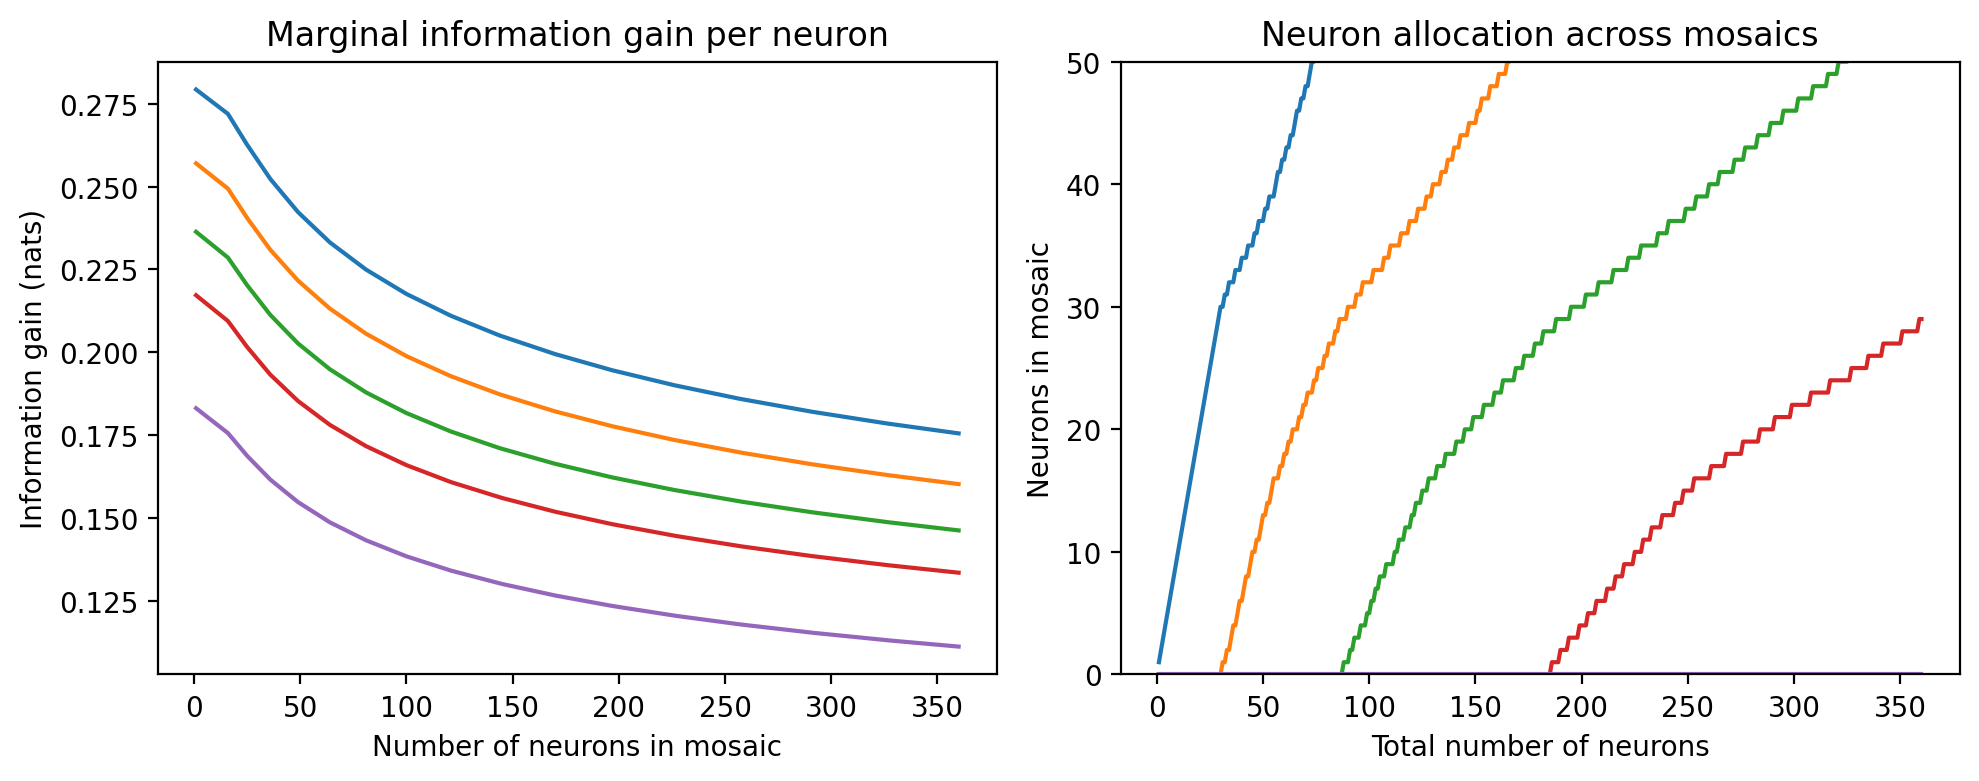

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4)) 

omega0_list = [10**x for x in [1.5, 1.52, 1.54, 1.56, 1.6]]
P0 = 1.5
J_list = [m**2 for m in range(2, 20)]
all_J_list = range(1, J_list[-1])

diff_info_fn_list = []
for omega0 in omega0_list:
    info = [information(omega0, J, J * P0) for J in J_list]
    
    # now interpolate for non-square J
    all_diff_info = interp1d(J_list[1:], np.diff(info), fill_value='extrapolate')
    diff_info_fn_list.append(all_diff_info)
    ax[0].plot(all_J_list, all_diff_info(all_J_list))

ax[0].set_title("Marginal information gain per neuron")
ax[0].set_xlabel("Number of neurons in mosaic")
ax[0].set_ylabel("Information gain (nats)")
    
marginal_allocation = np.zeros((len(all_J_list), len(omega0_list)))
for idx, J in enumerate(all_J_list):
    current_allocation = np.cumsum(marginal_allocation, axis=0)[idx]
    marginal_values = np.array([fun(A + 1) for A, fun in zip(current_allocation, diff_info_fn_list)])
    marginal_allocation[idx, np.argmax(marginal_values)] = 1
    
ax[1].plot(all_J_list, np.cumsum(marginal_allocation, axis=0))
ax[1].set_ylim(0, 50)
ax[1].set_title("Neuron allocation across mosaics")
ax[1].set_xlabel("Total number of neurons")
ax[1].set_ylabel("Neurons in mosaic")

plt.tight_layout()
#plt.savefig("figures/mosaic_allocation.pdf")

# Redefine some things to work in the continuous case

We'll define the filter using some different conventions more applicable in the continuous case.

In [17]:
L = 100  # linear size of space in one dimension
T = 50 # size of time
N = 10001 # number of points
M = 10001
zz = np.linspace(-L/2, L/2, N)
tt = np.linspace(-T/2, T/2, M)
dz = zz[1] - zz[0]
dt = tt[1] - tt[0]

freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
freqs_omega = scipy.fft.fftshift(scipy.fft.fftfreq(M, d=dt) * 2 * np.pi)
k_low = 0 
o_low = 0 
freqs_k_small = freqs_k[freqs_k > 2 * np.pi * k_low] #[(freqs_k > 0) & (freqs_k < 25)] 
freqs_omega_small = freqs_omega[freqs_omega > 2 * np.pi * o_low] #[(freqs_omega > 0) & (freqs_omega < 25)] 

oo, kk = np.meshgrid(freqs_omega_small, freqs_k_small)

In [23]:
def C(k,o,i):
    eigval = A[i]/(np.abs(k)**alpha * np.abs(o)**2)  
    return eigval

def create_information_eps(kf_noA, freqs, power, k_type):
    def information_eps(log_eps):
        infos = []
        for i in range(A.shape[0]):
            eps_eigenchannel = np.exp(log_eps[i])
            if k_type == 'kf':
                Af = A[i]**(1/alpha)
            elif k_type == 'of':
                Af = np.sqrt(A[i])
            kf = kf_noA*Af
            ktilde = np.abs(freqs/kf)**power

            numer = np.maximum(0, sigout**2 /(2 * (ktilde + 1e-32)) * (np.sqrt(1 + 4 * ktilde/(eps_eigenchannel * sigout**2)) - 1) - sigout**2) + sigout**2
            denom = np.maximum(0, sigout**2 /(2 * (ktilde + 1)) * (np.sqrt(1 + 4 * ktilde/(eps_eigenchannel * sigout**2)) + 1) - sigout**2) + sigout**2
            info = np.sum(np.log(numer) - np.log(denom))
            infos.append(info)
        return np.sum(infos)*-1
    return information_eps
    
def filter_k(kf, eps, k_lims=None, power=alpha):
    def v_opt(k):
        #print("eps:",eps, "k:", k, "kf:", kf, "power:", power)
        sqrt_piece = np.sqrt(1 + (4/eps) * np.abs(k/kf)**power)
        #print("sqrt_piece,", sqrt_piece)
        v2 = 0.5 * (sqrt_piece + 1) / (1 + np.abs(k/kf)**power) - 1
        #print("v2 v1", np.mean(v2))
        v2 = np.sqrt(np.maximum(v2, 0) * sigout**2/sigin**2)
        #print("v2 mean", np.mean(v2), np.abs(k/kf)**power)
        if k_lims:
            unit_cell_k = soft_bandpass(k_lims[0], k_lims[1], k)
            v2 *= unit_cell_k
        
        return v2
    return v_opt

def filter(C, nu, k_lims=None):
    def v_opt(k, o, i):
        CC = np.minimum(C(k, o, i), 1e32)
        sqrt_piece = np.sqrt(CC**2 + (4/nu) * (sigin**2/sigout**2) * CC)
        v2 = 0.5 * (sqrt_piece + CC) / (sigin**2 + CC) - 1
        v2 = np.sqrt(np.maximum(v2, 0) * sigout**2/sigin**2)
        
        if k_lims:
            unit_cell_k = soft_bandpass(k_lims[0], k_lims[1], k)
            v2 *= unit_cell_k
        
        return v2 #- np.min(v2)
    return v_opt

def pad_and_reflect(filter, N, padval=0):
    """
    Zero-pad to length N//2 and reflect about origin to make length N. 
    """
    expanded = np.pad(filter, (0, N//2 + 1 - len(filter)), constant_values=(0, padval))
    return np.concatenate([expanded[::-1], expanded[1:]])

def extrap_and_reflect(filter, N, return_log=False):
    """
    Linearly extrapolate the log filter to better approximate tails and reflect 
    about origin to make length N.
    """
    extrap_fun = interp1d(range(0, len(filter)), np.maximum(-32, np.log(filter)), fill_value='extrapolate')
    expanded = extrap_fun(range(0, N//2 + 1))
    if not return_log:
        expanded = np.exp(expanded)
    return np.concatenate([expanded[::-1], expanded[1:]])

def filter_power(eps, kf, freqs, klims, power):
    vfun = filter_k(kf, eps, klims, power)
    v2 = vfun(freqs)
    Ck = np.abs(freqs/kf)**power
    dk = freqs[1] - freqs[0]
    #print("subset of power", np.sum(v2**2))
    return np.sum(v2**2 * np.abs(freqs) * (Ck + sigin**2) * dk)/(2 * np.pi)**2

def excess_power(log_eps, kf_noA, freqs, klims, power, P, A_type):
    total_power = 0
    for i in range(A.shape[0]):
        #print(kf_noA*(A[i]**(1/alpha)))
        if A_type == 'kf':
            Af = A[i]**(1/alpha)
        elif A_type == 'of':
            Af = np.sqrt(A[i])
        eig_power = filter_power(10**log_eps[i], kf_noA*Af, freqs, klims, power)
        total_power += eig_power
        #print("eig_power", eig_power)
        #print("loss", P-total_power)
    return P - total_power

def optimal_logeps(kf_noA, freqs, klims, power, P, A_type):
    power_constraint = {'type': 'ineq', 'fun': excess_power, 'args': (kf_noA, freqs, klims, power, P, A_type)}
    eps_fun = create_information_eps(kf_noA, freqs, power, A_type)
    res = opt.minimize(eps_fun, np.array([-2,-2,-2]), bounds=[(-16, np.inf)], constraints=[power_constraint])
    if res.success:
        print("Excess power: ", excess_power(res.x, kf_noA, freqs, klims, power, P, A_type))
        return res.x
    else:
        print("Optimizer failed to converge!")
        return None

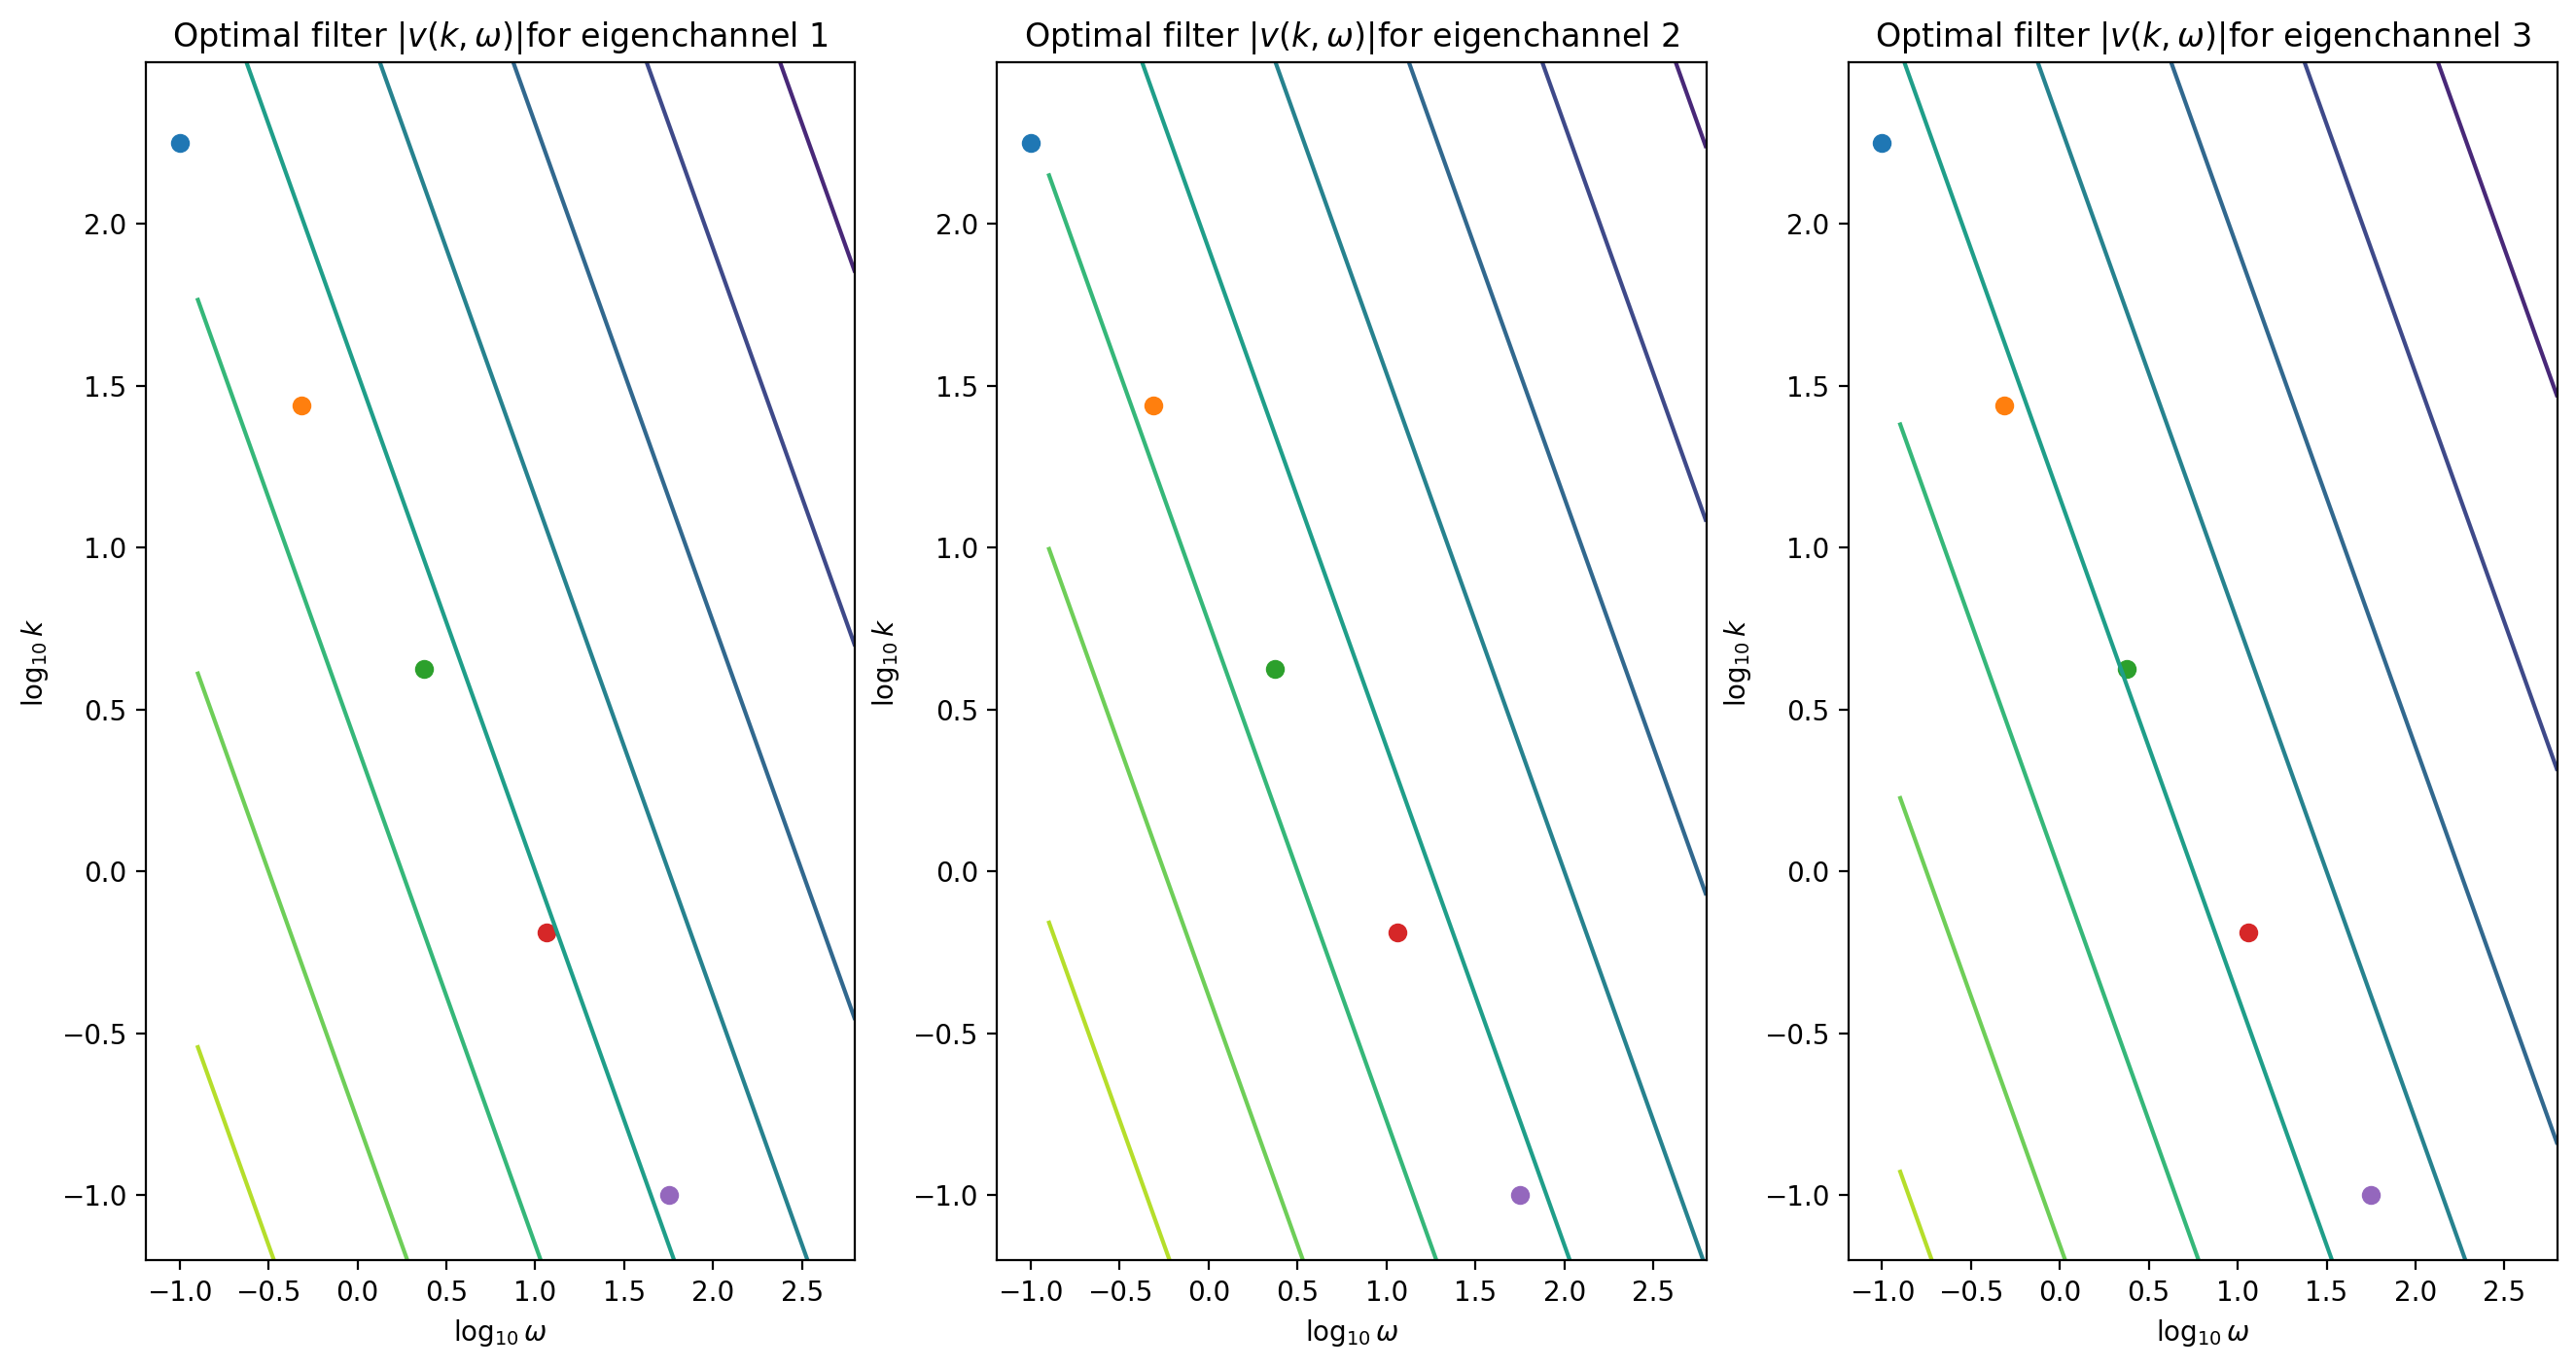

In [25]:
#Bug 1: needed to multiply kf by A**(1/alpha) instead of just A
omega_range_mul = 4
A = np.array([100,10,1])
if A.shape[0] > 1:
    n_plots = A.shape[0]
else: 
    n_plots = 2
fig, ax = plt.subplots(1, n_plots, figsize=(16, 8))
k0_list = [10**k0 for k0 in np.linspace(2.25, -1, 5)]
o0_list = [10**o0 for o0 in np.linspace(-0.25*omega_range_mul, 1.75, 5)]

kf_list_noA = [(sigin**2/o0**2)**(1/alpha) for o0 in o0_list]
of_list_noA = [np.sqrt(sigin**2/k0**alpha) for k0 in k0_list]

for i in range(A.shape[0]):
    vfun = filter(C, 1e-4)
    Ck = C(kk, oo, i)
    ax[i].contour(np.log10(oo), np.log10(kk), np.log10(Ck), levels=10)
    ax[i].set_title(r"Optimal filter $|v(k, \omega)|$" + "for eigenchannel " + str(i+1))
    ax[i].set_ylabel(r"$\log_{10} k$")
    ax[i].set_xlabel(r"$\log_{10} \omega$");
    #ax[i].text(*label_loc, r'\textbf{A}', transform=ax[i].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')
    
    for kf_noA, of_noA in zip(kf_list_noA, of_list_noA):
        kf = kf_noA*A[i]**(1/alpha)
        of = of_noA*np.sqrt(A[i])
        o0 = np.sqrt(A[i]/sigin**2/kf**alpha)
        k0 = (A[i]/sigin**2/of**2)**(1/alpha)
        ax[i].scatter(np.log10(o0), np.log10(k0))


Excess power:  -1.6615775422224033e-10
[ 0.13022092  0.02001571 -0.21659407]


C:\Users\David\AppData\Local\Temp\ipykernel_6056\2789938205.py:27: RuntimeWarning: invalid value encountered in divide
  vspace /= np.linalg.norm(vspace)


Excess power:  -3.856880392838491e-08
[ 0.15943378 -0.00351002 -0.64780581]


KeyboardInterrupt: 

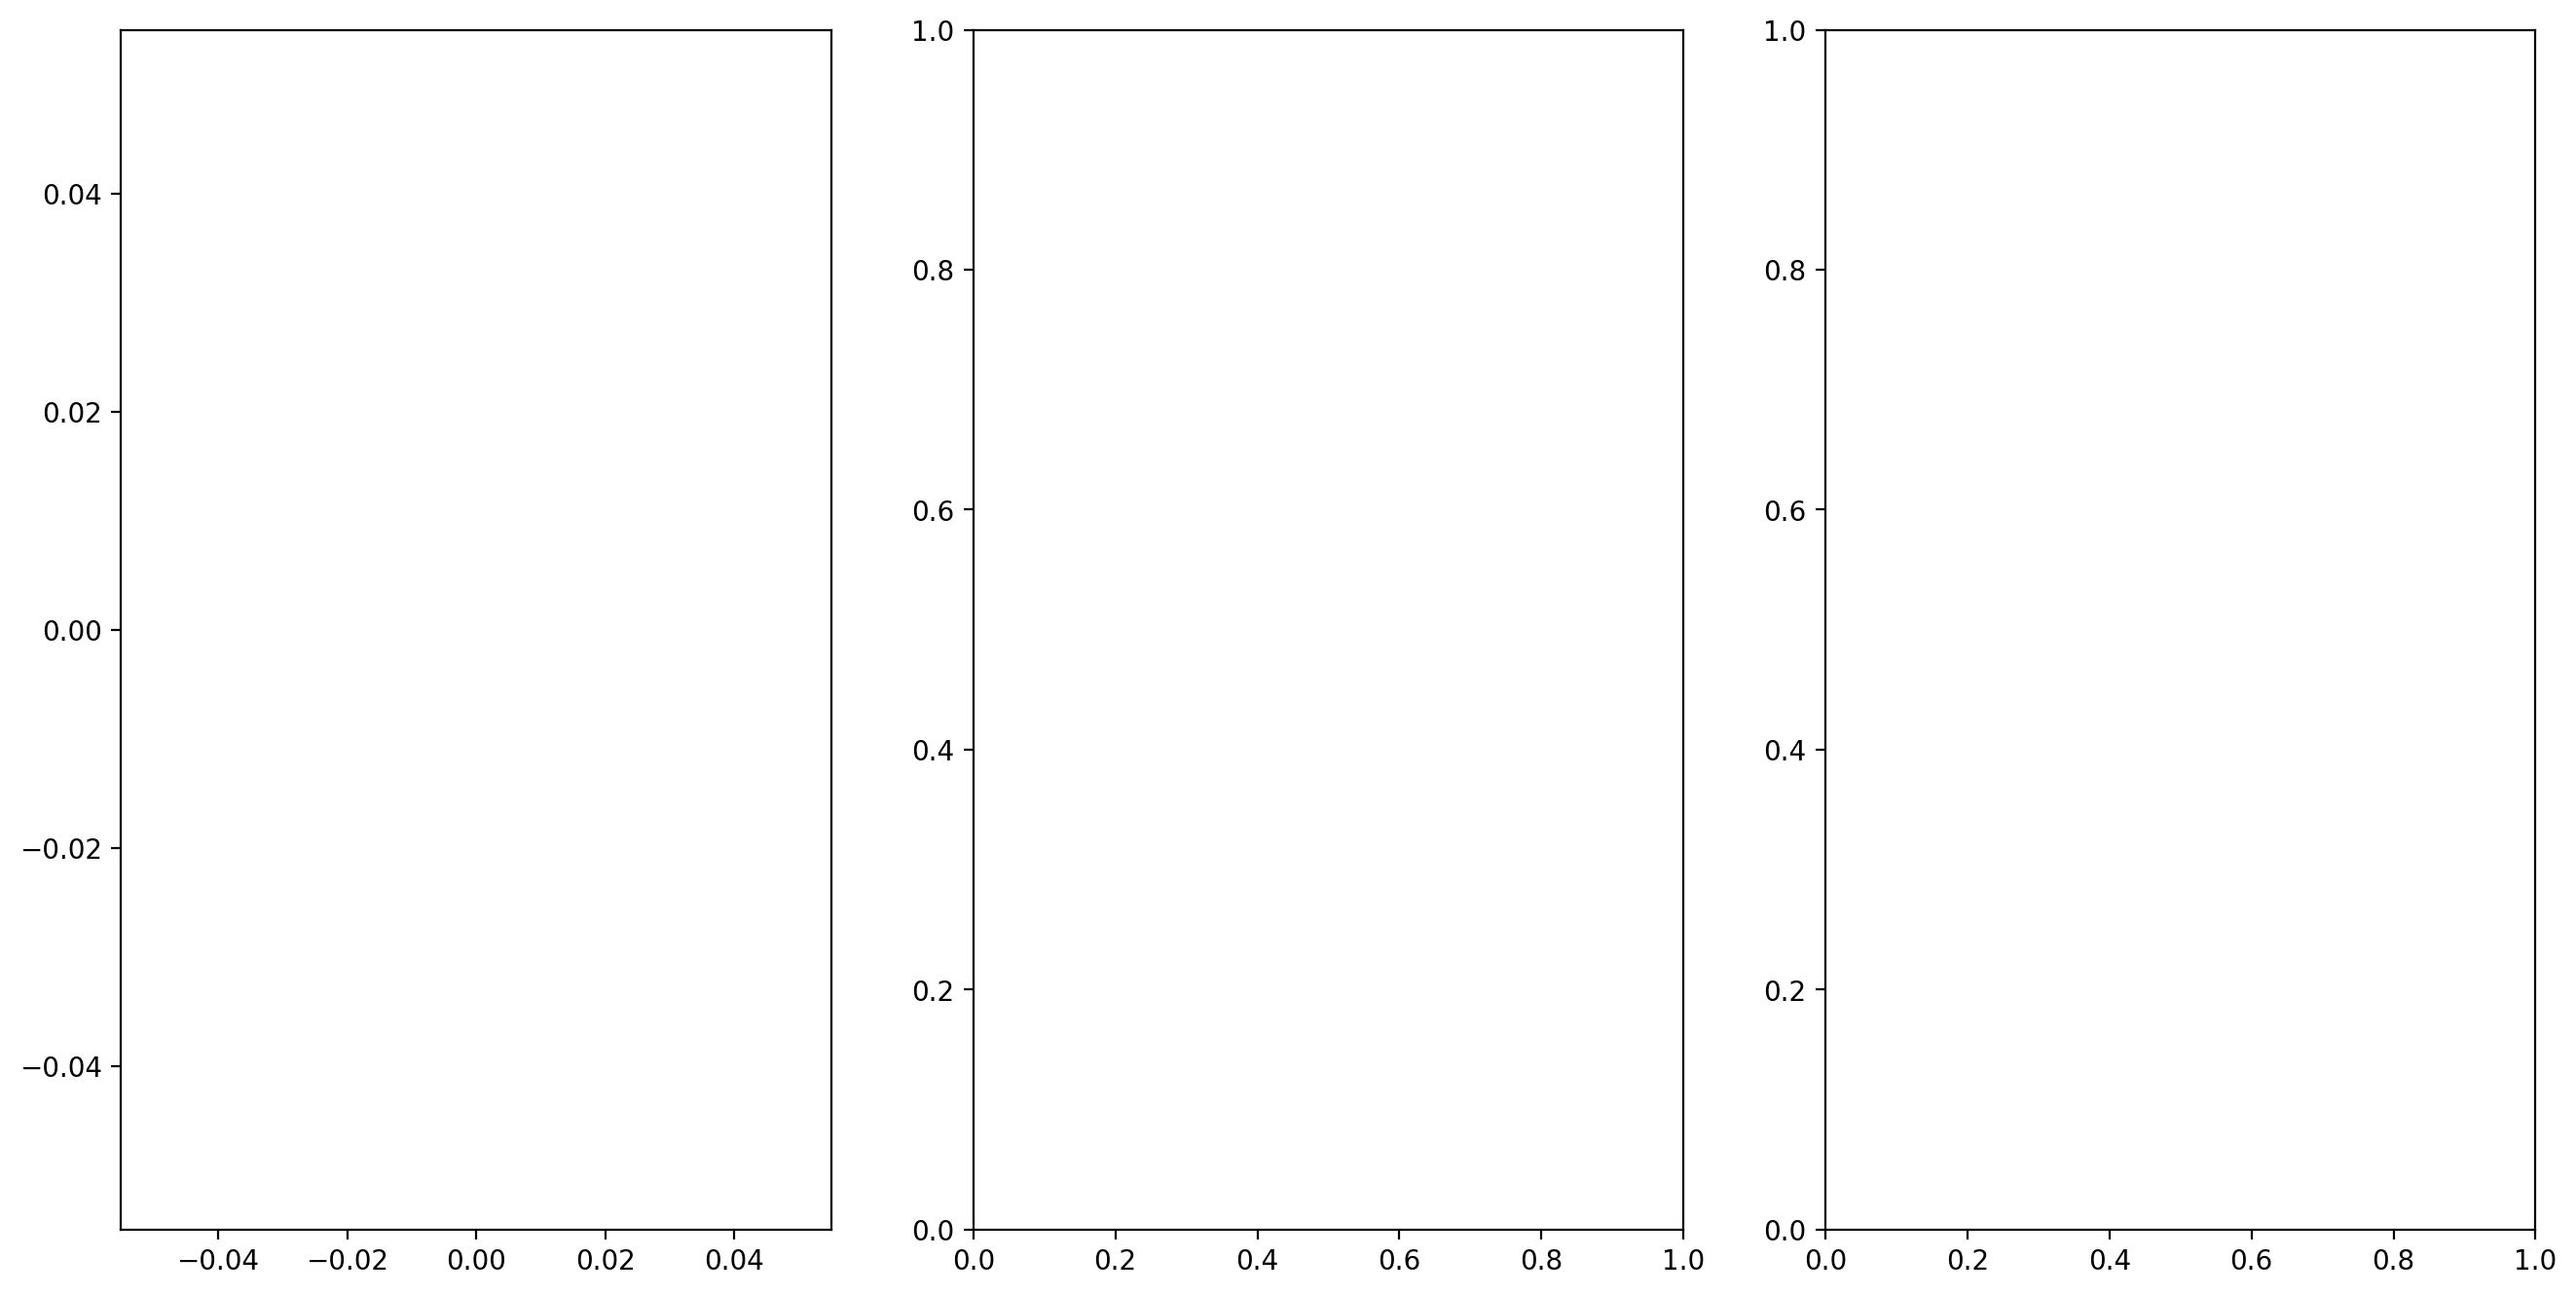

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
P = 1
dz = 1e-4
N = 1000001
freqs_k = scipy.fft.fftshift(scipy.fft.fftfreq(N, d=dz) * 2 * np.pi)
L = (N//2) * dz
zz = np.linspace(-L/2, L/2, N)

# make a double exponential smoothing filter
fz = np.arange(-.2, .2, dz)
ff = np.exp(-50 * np.abs(fz))
ff /= np.sum(ff)
vspace_all = []

colors = ['red', 'green', 'blue', 'purple', 'orange']
for i in range(A.shape[0]):
    c = 0
    lines = []
    for kf_noA in kf_list_noA:
        log_eps = optimal_logeps(kf_noA, freqs_k, None, alpha, P, 'kf')
        print(log_eps)
        kf = kf_noA*(A[i]**(1/alpha))
        vv = filter_k(kf, 10**log_eps[i])(freqs_k)
        vf = np.convolve(vv[N//2:], ff, mode='same')
        vvf = pad_and_reflect(vf, N)
        vspace = np.real(scipy.fft.fftshift(scipy.fft.fft(scipy.fft.ifftshift(vvf))))
        vspace /= np.linalg.norm(vspace)
        if np.mean(vspace) == 0:
            print("Zero vspace for kf: ", kf_noA)
        line, = ax[i].plot(zz, vspace, color = colors[c], label = str(('{:.3f}').format(o0_list[c])))
        lines.append(line)
        vspace_all.append(vspace)
        c += 1

    ax[i].set_xlim(-0.2, 0.2)   
    #ax[i].set_yticks([])
    ax[i].set_xlabel(r"$z$")
    ax[i].set_title(r"Spatial filter $v(z)$ for A = " + str(A[i]));
    if i == A.shape[0]-1:
        ax[i].legend(handles=lines, title = "Temporal frequency", fontsize = 12)
    #ax[0].text(*label_loc, r'\textbf{B}', transform=ax[0].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')
    #cbar = fig.colorbar(s)
    #cbar.ax.tick_params(labelsize=50)

[0.034474660657314936,
 0.11631212760441838,
 0.3924189758484536,
 1.323960413910436,
 4.466835921509631]

NameError: name 'P' is not defined

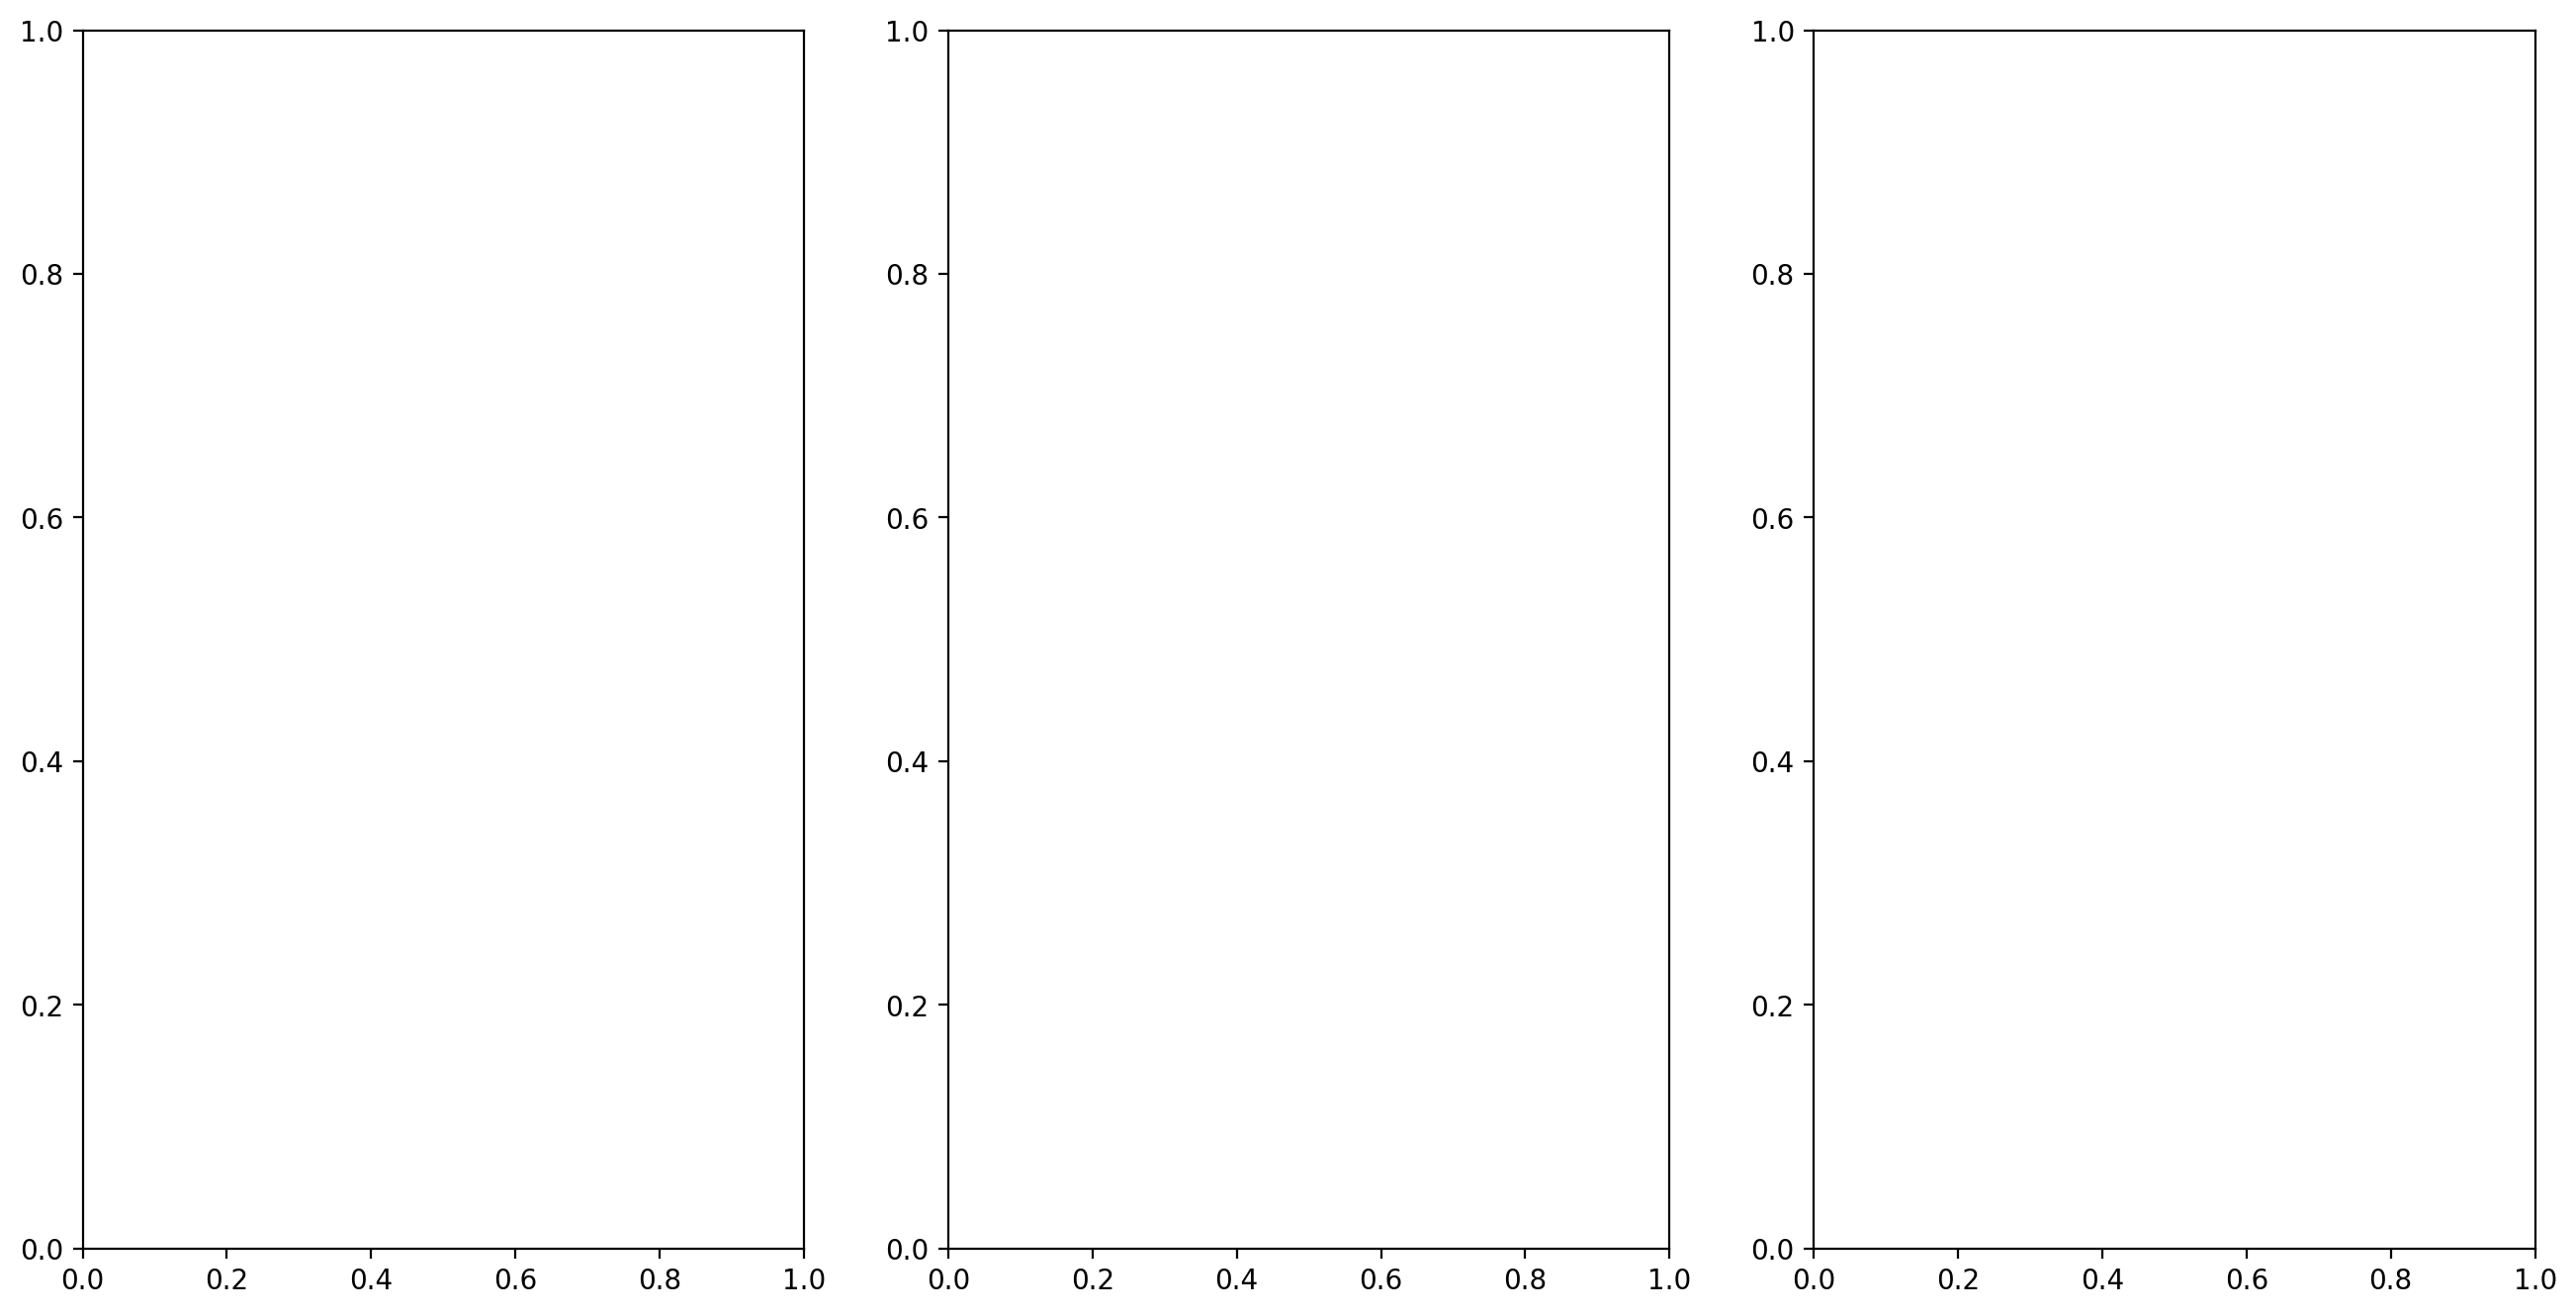

In [20]:
A = np.array([100, 10,1])
fig, ax = plt.subplots(1, 3, figsize=(16, 8))
dt = 1e-4
M = 1000001
freqs_o = scipy.fft.fftshift(scipy.fft.fftfreq(M, d=dt) * 2 * np.pi)
T = (M//2) * dt
tt = np.linspace(-T/2, T/2, M)
for i in range(A.shape[0]):
    for of_noA in of_list_noA:
        log_eps = optimal_logeps(of_noA, freqs_o, None, 2, P)
        vv = filter_k(of_noA*np.sqrt(A[i]), 10**log_eps[i], power=2)(freqs_o)
        vf = np.convolve(vv[M//2:], ff, mode='same')
        log_v = extrap_and_reflect(vf, M, return_log=True)
        log_v_a = np.conj(ssig.hilbert(log_v))
        vt = np.real(scipy.fft.fftshift(scipy.fft.fft(scipy.fft.ifftshift(np.exp(log_v_a)))))
        vt /= np.linalg.norm(vt)
        
        ax[i].plot(tt, vt)

ax[i].set_xlim(-0.35, 0)
ax[i].set_xlabel(r"$t$")
ax[i].set_yticks([])
ax[i].set_title(r"Temporal filter $v(t)$");
ax[i].text(*label_loc, "C", transform=ax[i].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')



In [157]:
k0_list = [10**k0 for k0 in np.linspace(2.25, -1, 5)]
o0_list = [10**o0 for o0 in np.linspace(-0.25*omega_range_mul, 1.75, 5)]

kf_list_noA = [(sigin**2/o0**2)**(1/alpha) for o0 in o0_list]
of_list_noA = [np.sqrt(sigin**2/k0**alpha) for k0 in k0_list]
np.array(kf_list_noA)*(100**(1/alpha))
np.array(of_list_noA)*np.sqrt(100)

array([ 0.34474661,  1.16312128,  3.92418976, 13.23960414, 44.66835922])

In [ ]:
cmap = sns.color_palette('rocket')
kf = 50

J_list = [1, 4, 9, 16, 25]
for idx, J in enumerate(J_list):
    k_lims = (0, np.sqrt(J) * 8)
    log_eps = optimal_logeps(kf, freqs_k, k_lims, alpha, P)
    vv = filter_k(kf, 10**log_eps, k_lims)(freqs_k)
    vf = np.convolve(vv[N//2:], ff, mode='same')
    vvf = pad_and_reflect(vf, N)
    vspace = np.real(scipy.fft.fftshift(scipy.fft.fft(scipy.fft.ifftshift(vvf))))
    vspace /= np.linalg.norm(vspace)    
    ax[1, 0].plot(zz, vspace, color=cmap[idx], label=J)

ax[1, 0].set_xlim(-0.2, 0.2)
ax[1, 0].set_yticks([])
ax[1, 0].set_xlabel(r"$z$")
ax[1, 0].set_title(r"Spatial filter $v(z)$")
ax[1, 0].legend(title="Neurons", loc='upper right')
ax[1, 0].text(*label_loc, r'\textbf{D}', transform=ax[1, 0].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')



for idx in range(len(diff_info_fn_list)):
    all_diff_info = diff_info_fn_list[idx]
    ax[1, 1].plot(all_J_list, all_diff_info(all_J_list))

ax[1, 1].set_title("Marginal information gain per neuron")
ax[1, 1].set_xlabel("Number of neurons in mosaic")
ax[1, 1].set_ylabel("Information gain (nats)")
ax[1, 1].text(*label_loc, r'\textbf{E}', transform=ax[1, 1].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')
    

Excess power:  -1.7180000044803023e-07
[ 0.34820823 -0.00302869 -0.49629691]


/tmp/ipykernel_237771/3867812646.py:48: RuntimeWarning: invalid value encountered in divide
  vspace /= np.linalg.norm(vspace)


(1000001,) (1000001,)
Excess power:  -9.7757264061471e-07
[-1.16016489e-03 -9.26053616e-01 -1.18579582e+00]
(1000001,) (1000001,)
Excess power:  -1.0263746608174529e-07
[-1.50309244 -0.38950636 -1.41164287]
(1000001,) (1000001,)
Excess power:  0.9834975803101909
[-2. -2. -2.]
(1000001,) (1000001,)
Excess power:  1.0
[-2. -2. -2.]
(1000001,) (1000001,)
Excess power:  -1.7180000044803023e-07
[ 0.34820823 -0.00302869 -0.49629691]
(1000001,) (1000001,)
Excess power:  -9.7757264061471e-07
[-1.16016489e-03 -9.26053616e-01 -1.18579582e+00]
(1000001,) (1000001,)
Excess power:  -1.0263746608174529e-07
[-1.50309244 -0.38950636 -1.41164287]
(1000001,) (1000001,)
Excess power:  0.9834975803101909
[-2. -2. -2.]
(1000001,) (1000001,)
Excess power:  1.0
[-2. -2. -2.]
(1000001,) (1000001,)
Excess power:  -1.7180000044803023e-07
[ 0.34820823 -0.00302869 -0.49629691]
(1000001,) (1000001,)
Excess power:  -9.7757264061471e-07
[-1.16016489e-03 -9.26053616e-01 -1.18579582e+00]
(1000001,) (1000001,)
Excess p

NameError: name 'of_list' is not defined

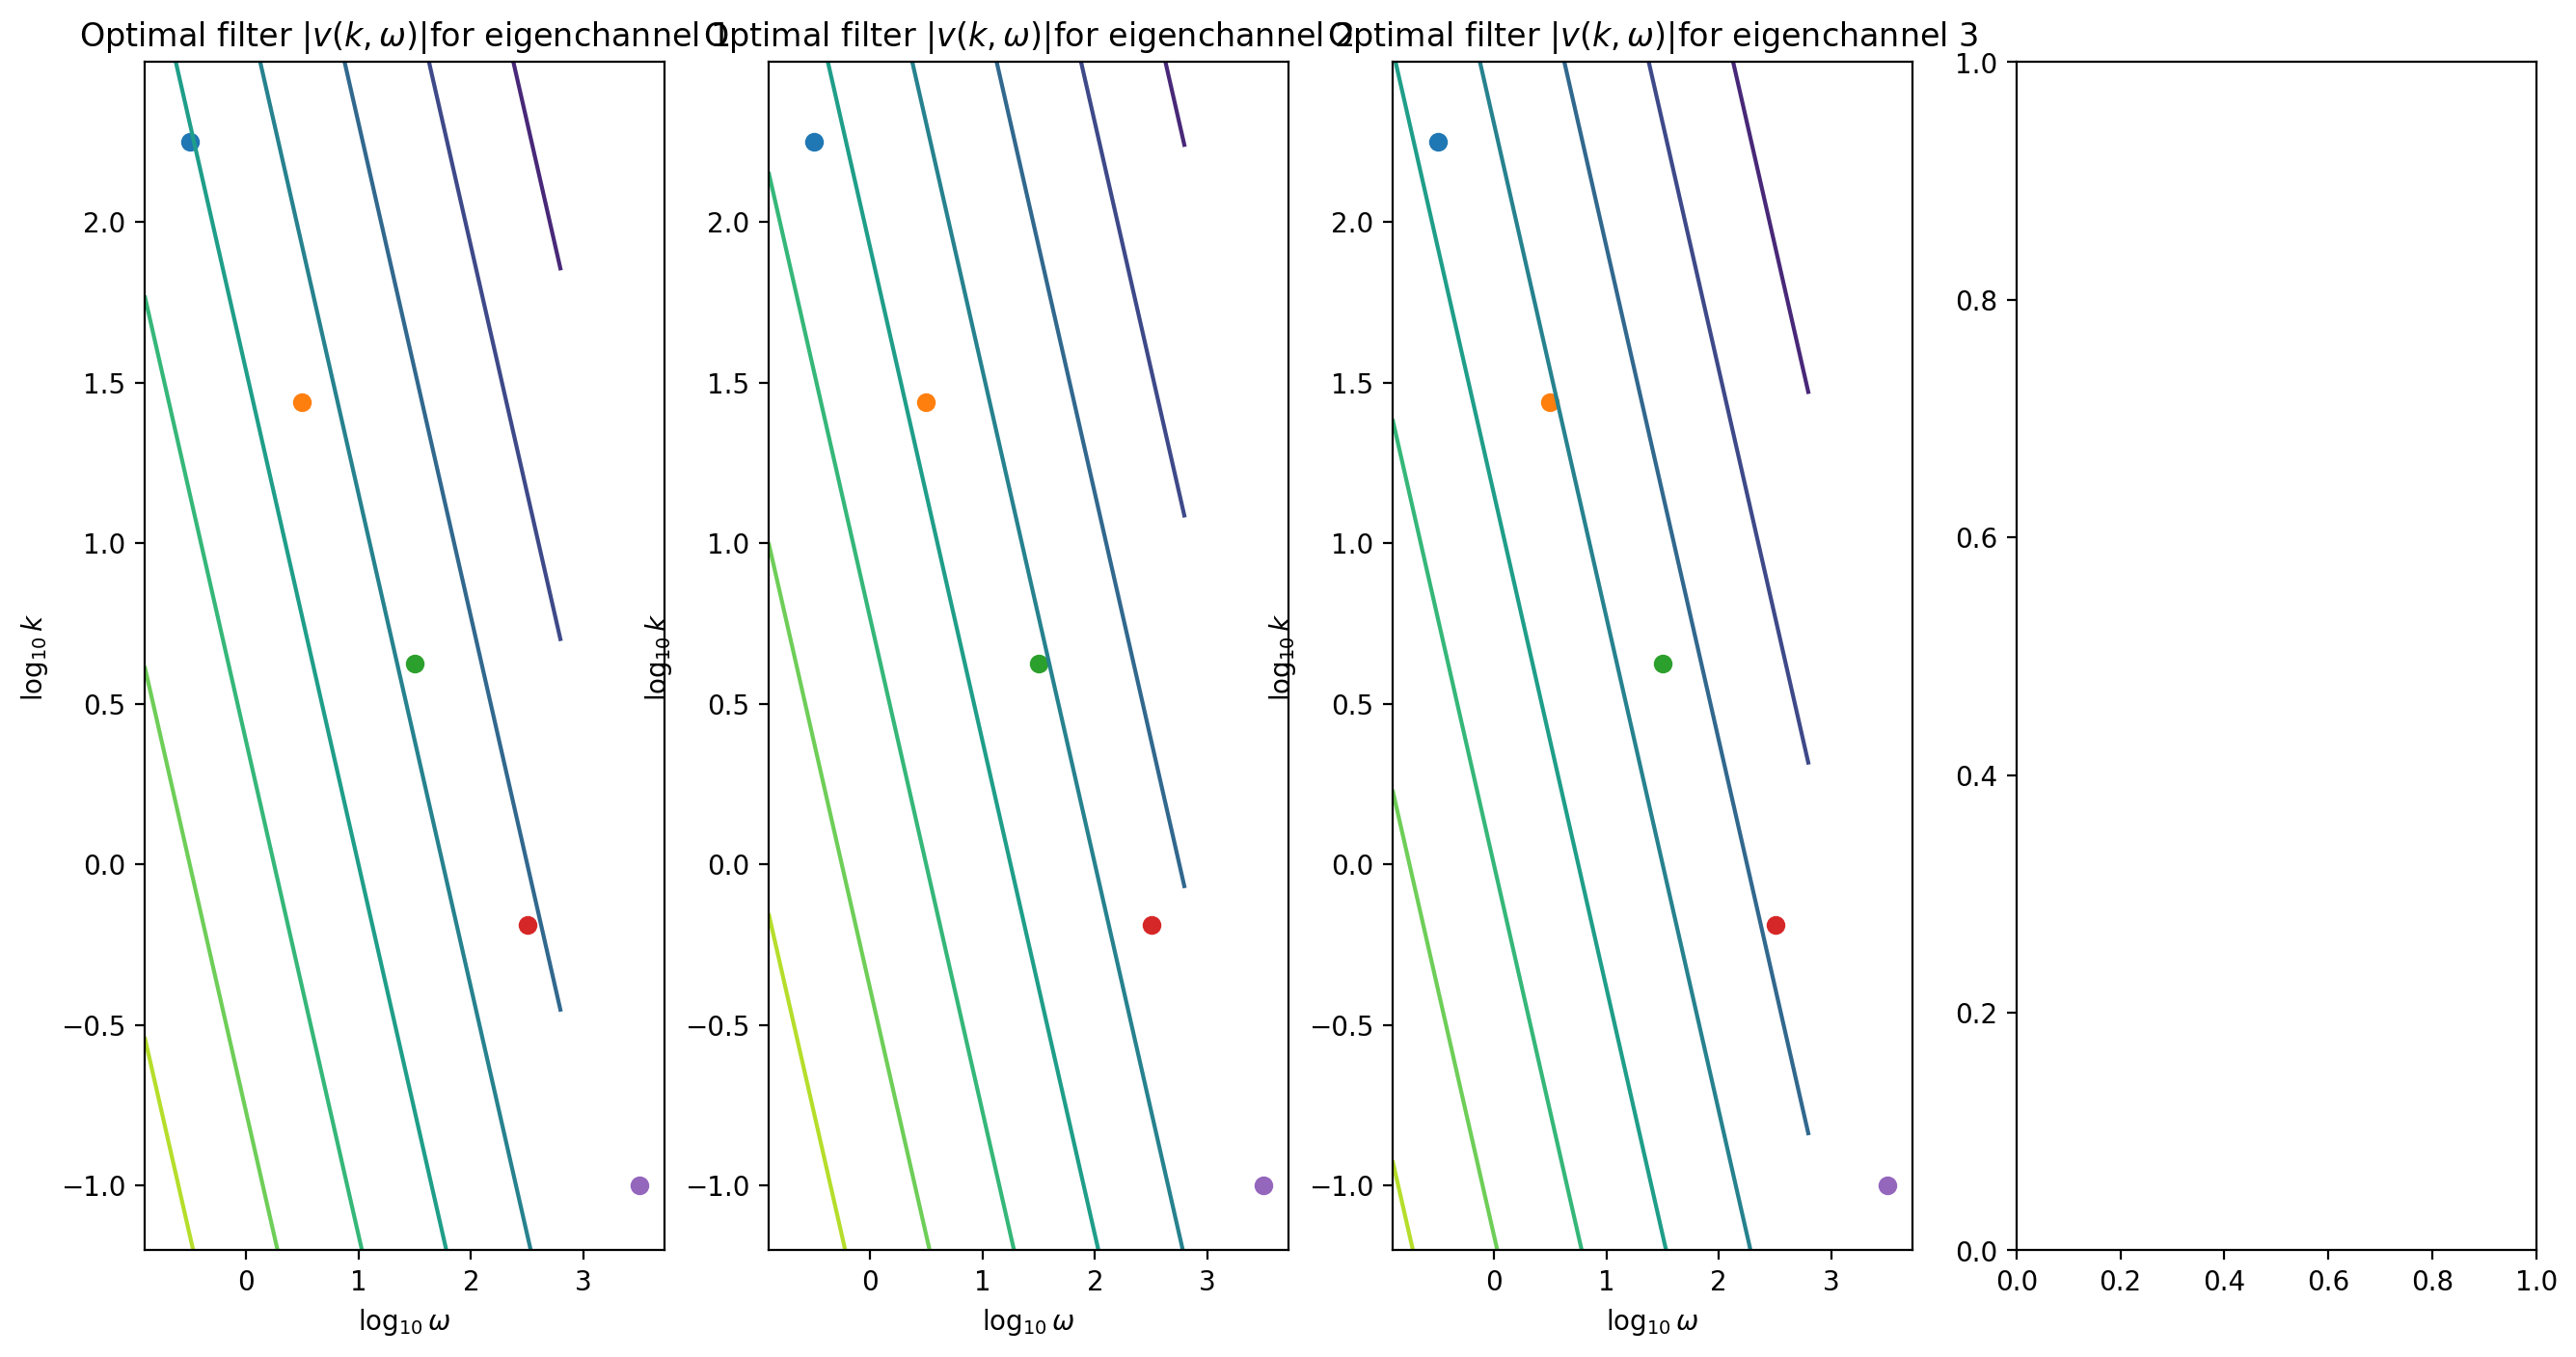

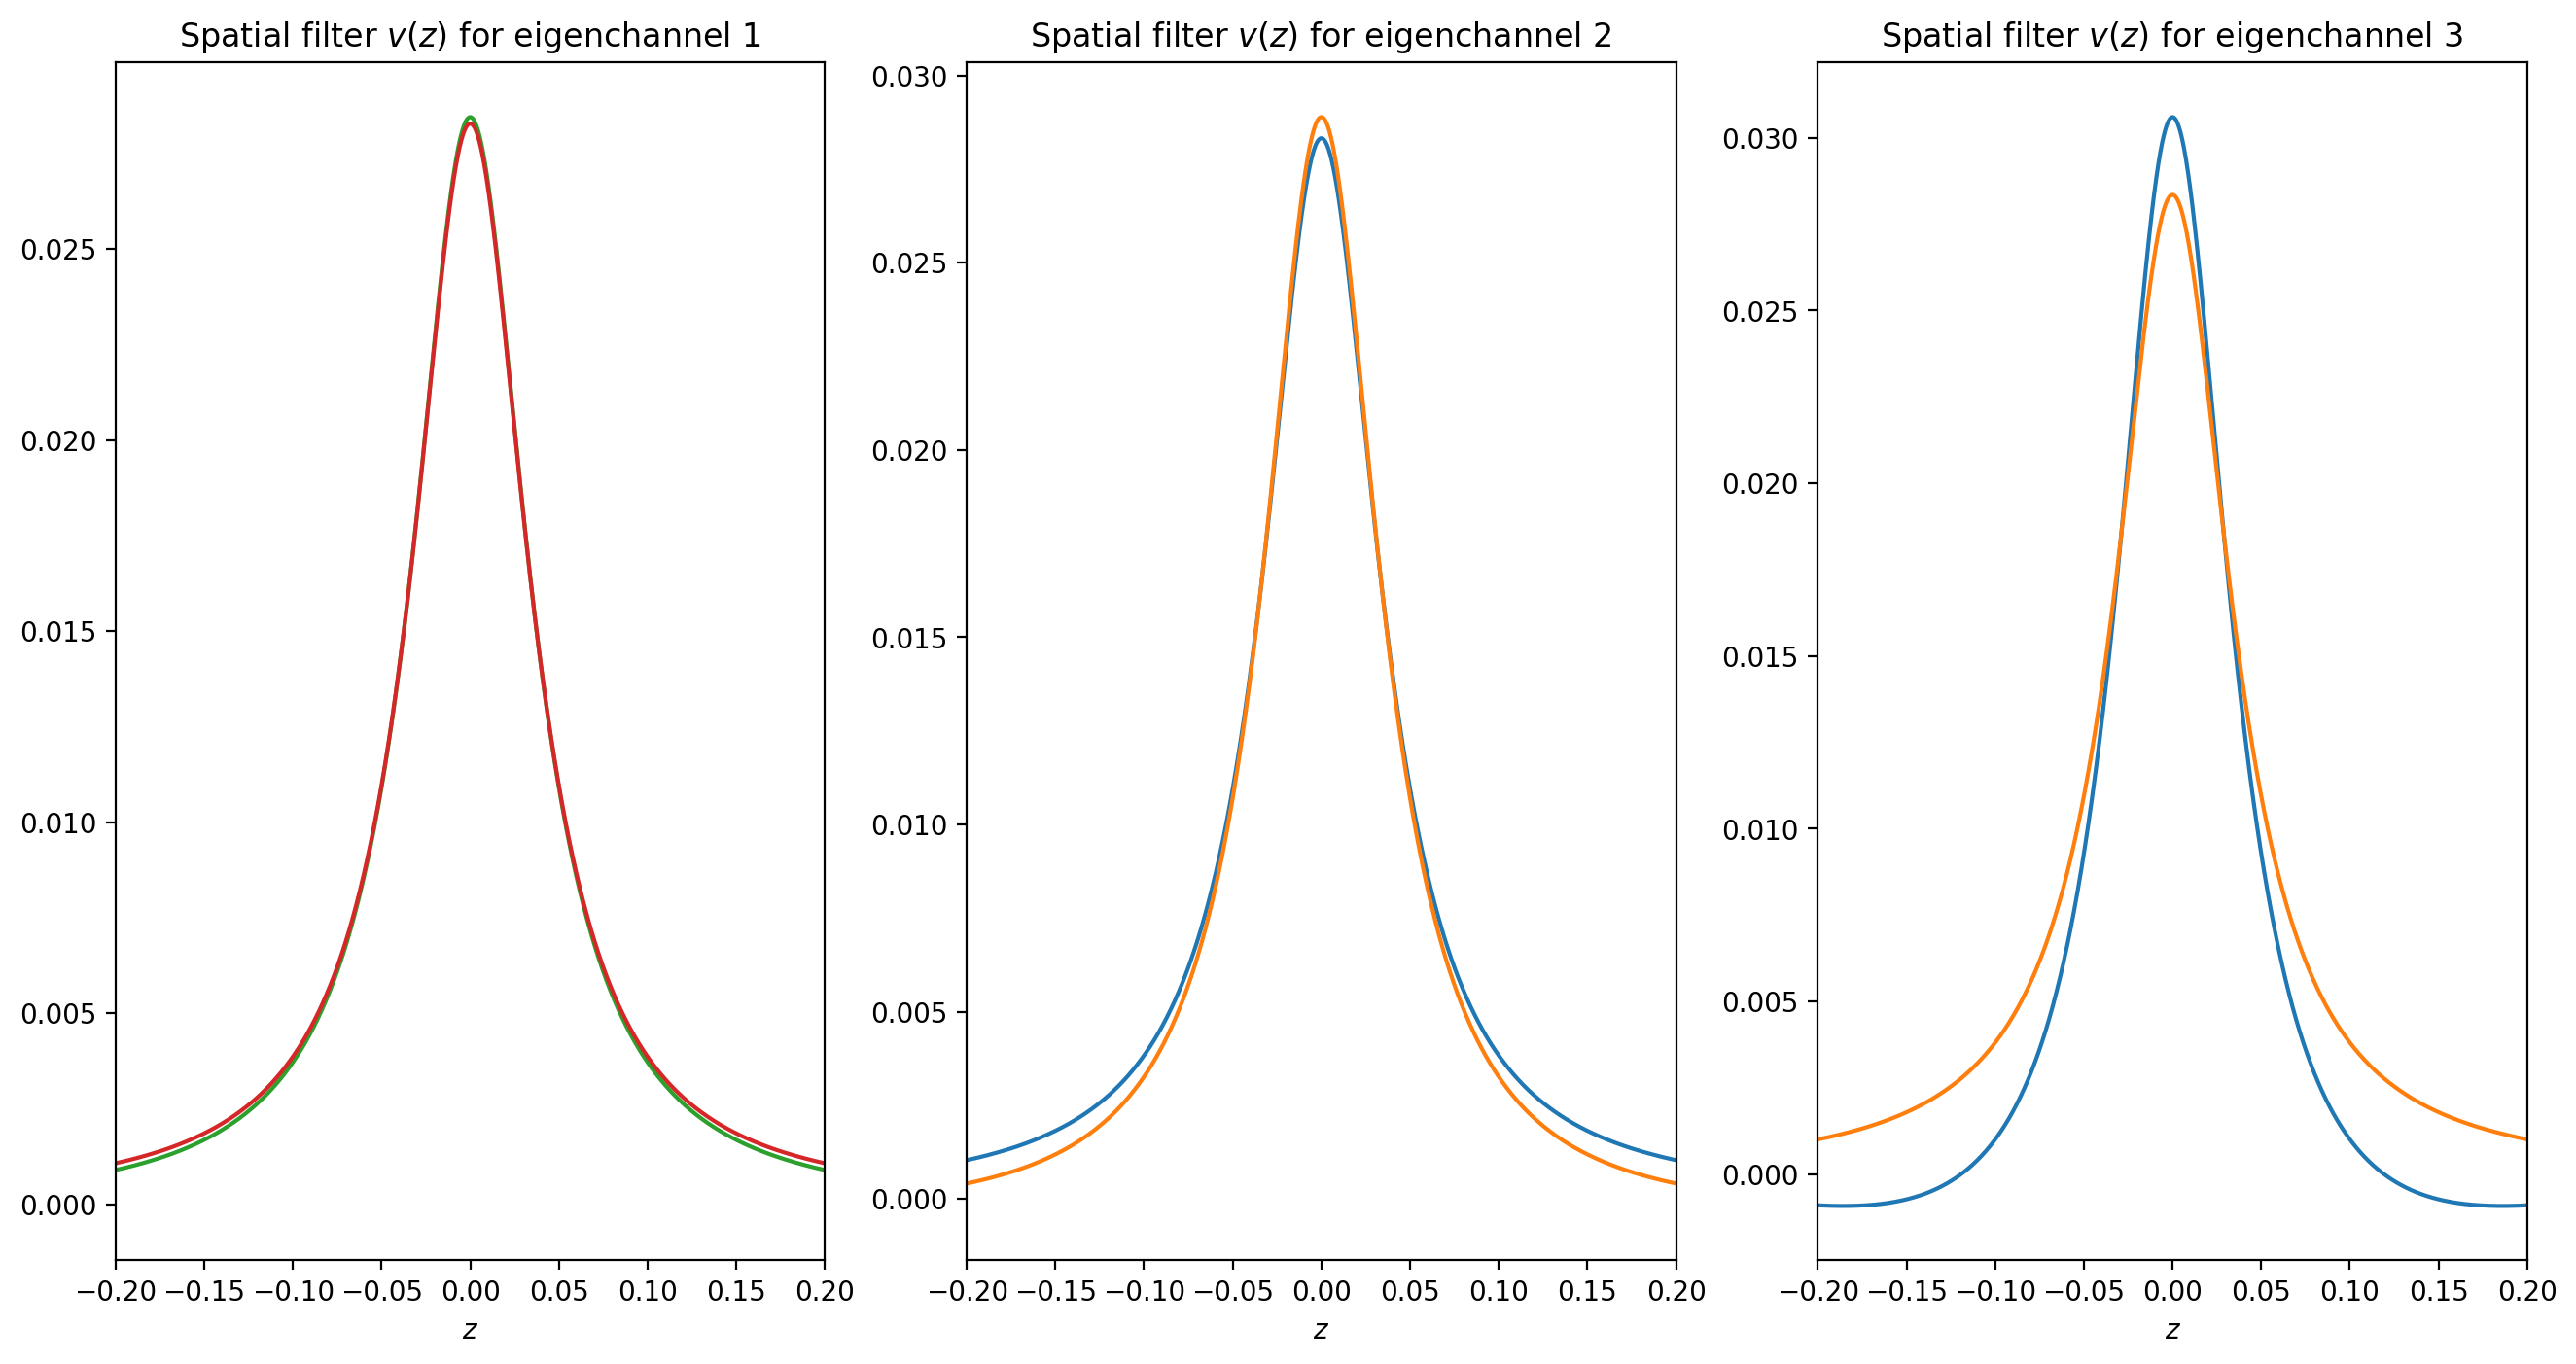

In [114]:

ax[1, 2].plot(all_J_list, np.cumsum(marginal_allocation, axis=0))
ax[1, 2].set_ylim(0, 50)
ax[1, 2].set_title("Neuron allocation across mosaics")
ax[1, 2].set_xlabel("Total number of neurons")
ax[1, 2].set_ylabel("Neurons in mosaic")
ax[1, 2].text(*label_loc, r'\textbf{F}', transform=ax[1, 2].transAxes, fontsize=fontsize, fontweight=fontweight, va='top')

plt.tight_layout()
plt.savefig("figures/optimal_linear_spacetime.pdf")

In [99]:
kf_noA*(A[0]**(1/alpha))

0.07017038286703829

In [113]:
vspace

array([nan, nan, nan, ..., nan, nan, nan])